In [1]:
import json
import matplotlib.pyplot as plt
import random 
import requests
import time
import uuid
import datetime

# Personalizer 리소스 키 및 이름 설정
* Personalizer 리소스에 대한 Azure Portal의 빠른 시작 페이지에서 키와 엔드포인트를 찾습니다. 
* "your-resource-name" 값을 Personalizer 리소스의 이름으로 변경합니다. "your-resource-key" 값을 Personalizer 키로 변경합니다.

In [2]:
# Replace 'personalization_base_url' and 'resource_key' with your valid endpoint values.
personalization_base_url = "https://recommend-coffee-02.cognitiveservices.azure.com/"
resource_key = "dd735b29f06e44d3ae7e117aa73ace8d"

# Print current data and time

In [3]:
# Print out current datetime
def currentDateTime():
    currentDT = datetime.datetime.now()
    print (str(currentDT))

In [4]:
currentDateTime()

2021-08-11 10:50:48.807251


# Get the last model update date and time

In [5]:
# ititialize variable for model's last modified date
modelLastModified = ""

In [6]:
def get_last_updated(currentModifiedDate):
    
    print('-----checking model')
    
    # get model properties
    response = requests.get(personalization_model_properties_url, headers = headers, params = None)
    
    print(response)
    print(response.json())
    
    # get lastModifiedTime
    lastModifiedTime = json.dumps(response.json()["lastModifiedTime"])
    
    if (currentModifiedDate != lastModifiedTime):
        currentModifiedDate = lastModifiedTime
        print(f'-----model updated: {lastModifiedTime}')

# Get policy and service configruation

In [7]:
def get_service_settings():
    
    print('-----checking service settings')
    
    # get learning policy
    response = requests.get(personalization_model_policy_url, headers = headers, params = None)
    
    print(response)
    print(response.json())
    
    # get service settings
    response = requests.get(personalization_service_configuration_url, headers = headers, params = None)
    
    print(response)
    print(response.json())

# URL 생성 및 JSON 데이터 파일 읽기

* 이 셀에서 다음을 수행합니다.
    * REST API 호출에 사용되는 URL을 작성합니다.
    * Personalizer 리소스 키를 사용하여 보안 헤더를 설정합니다.
    * 순위 이벤트 ID의 임의 시드를 설정합니다.
    * JSON 데이터 파일을 읽습니다.
    * get_last_updated 메서드를 호출합니다. 예제 출력에서 학습 정책이 제거됩니다.
    * get_service_settings 메서드를 호출합니다.

In [8]:
# build URLs
personalization_rank_url = personalization_base_url + "personalizer/v1.0/rank"
personalization_reward_url = personalization_base_url + "personalizer/v1.0/events/" #add "{eventId}/reward"
personalization_model_properties_url = personalization_base_url + "personalizer/v1.0/model/properties"
personalization_model_policy_url = personalization_base_url + "personalizer/v1.0/configurations/policy"
personalization_service_configuration_url = personalization_base_url + "personalizer/v1.0/configurations/service"
headers = {'Ocp-Apim-Subscription-Key' : resource_key, 'Content-Type': 'application/json'}

# context
users = "demo_data/users.json"

# action features
coffee = "demo_data/coffee.json"

# empty JSON for Rank request
requestpath = "demo_data/example-rankrequest.json"

# initialize random
random.seed(time.time())

userpref = None 
rankactionsjsonobj = None 
actionfeaturesobj = None

with open(users) as handle:
    userpref = json.loads(handle.read())

with open(coffee) as handle:
    actionfeaturesobj = json.loads(handle.read())
    
with open(requestpath) as handle:
    rankactionsjsonobj = json.loads(handle.read())  
    
get_last_updated(modelLastModified)
get_service_settings()

print(f'User count {len(userpref)}')
print(f'Coffee count {len(actionfeaturesobj)}')

-----checking model
<Response [200]>
{'creationTime': '2021-08-11T01:47:56+00:00', 'lastModifiedTime': '2021-08-11T01:49:19+00:00'}
-----model updated: "2021-08-11T01:49:19+00:00"
-----checking service settings
<Response [200]>
{'name': 'b1c561f6faf943d087cc0442c50d4e73', 'arguments': '--cb_explore_adf --epsilon 0.20000000298023224 --power_t 0 -l 0.001 --cb_type mtr -q ::'}
<Response [200]>
{'rewardWaitTime': 'PT10M', 'defaultReward': 0.0, 'rewardAggregation': 'earliest', 'explorationPercentage': 0.2, 'modelExportFrequency': 'PT5M', 'logRetentionDays': 90, 'lastConfigurationEditDate': '2021-08-11T01:49:19', 'learningMode': 'Online'}
User count 4
Coffee count 4


# 고유 이벤트 ID 생성
* 이 함수는 각 Rank API호출에 대한 고유 ID를 생성합니다. 
* ID는 순위 및 보상 호출 정보를 식별하는 데 사용됩니다. 이 값은 웹 보기 ID 또는 트랜잭션 ID와 같은 비즈니스 프로세스에서 가져올 수 있습니다.
* 셀에는 출력이 없습니다. 이 함수가 호출되면 고유 ID를 출력합니다.

In [9]:
def add_event_id(rankjsonobj):
    eventid = uuid.uuid4().hex
    rankjsonobj["eventId"] = eventid
    return eventid

# Add context features 
* 실제 프로덕션 환경에서 발생하는 Context feature로 가정하여 랜덤 생성
* 임의 사용자, 날씨 및 하루 중 시간 가져오기

In [10]:
def add_random_user_and_contextfeatures(namesoption, weatheropt, timeofdayopt, rankjsonobj):
    name = namesoption[random.randint(0,3)]
    weather = weatheropt[random.randint(0,2)]
    timeofday = timeofdayopt[random.randint(0,2)]
    rankjsonobj['contextFeatures'] = [{'timeofday': timeofday, 'weather': weather, 'name': name}]
    return [name, weather, timeofday]

# Add action features 
* 모든 커피 데이터 추가

In [11]:
def add_action_features(rankjsonobj):
    rankjsonobj["actions"] = actionfeaturesobj

# Compare Rank API's prediction with known user preference
* 각 반복에 대해 순위 API 호출이 호출되면 이 함수가 호출됩니다.
* 이 함수는 날씨와 시간을 기준으로 커피에 대한 사용자의 기본 설정을 해당 필터에 대한 사용자의 Personalizer 제안과 비교합니다. 
* 제안이 일치하면 1의 점수가 반환되고, 그렇지 않으면 점수가 0입니다. 
* 셀에는 출력이 없습니다. 이 함수가 호출되면 점수를 출력합니다.

In [12]:
def get_reward_from_simulated_data(name, weather, timeofday, prediction):
    if(userpref[name][weather][timeofday] == str(prediction)):
        return 1
    return 0

# 본 데모에서는 User Preference 정답지와 결과가 일치하면 보상점수를 1으로 가정하였음
# 프로덕션 환경에서는 비즈니스 목적에 따라 설정한 사용자 액선을 반환받고 (클릭, 스크롤, 머문 시간... ) 
# 그에 따른 보상 점수를 세팅함

# Loop through calls to Rank and Reward
* 임의의 사용자와 제품목록을 가져오며, 둘 모두를 Rank API에 보내는 Notebook의 main 작업
* 예측과 사용자의 기본 설정을 비교하여, Personalizer 서비스에 Reward 반환 
* 루프는 num_requests회 실행됨. Personalizer에서 모델을 만들려면 순위 및 보상에 대한 수천 개의 호출이 필요합니다.

In [13]:
def iterations(n, modelCheck, jsonFormat):

    i = 1
    
    # default reward value - assumes failed prediction
    reward = 0

    # Print out dateTime
    #currentDateTime()

    # collect results to aggregate in graph
    total = 0
    rewards = []
    count = []

    # default list of user, weather, time of day
    namesopt = ['Alice', 'Bob', 'Cathy', 'Dave']
    weatheropt = ['Sunny', 'Rainy', 'Snowy']
    timeofdayopt = ['Morning', 'Afternoon', 'Evening']
    
    
    while(i <= n):

        # create unique id to associate with an event
        eventid = add_event_id(jsonFormat)

        # generate a random sample
        [name, weather, timeofday] = add_random_user_and_contextfeatures(namesopt, weatheropt, timeofdayopt, jsonFormat)

        # add action features to rank
        add_action_features(jsonFormat) 

        # show JSON to send to Rank
        #print('To: ', jsonFormat)    

        # choose an action - get prediction from Personalizer
        response = requests.post(personalization_rank_url, headers = headers, params = None, json = jsonFormat)

        # show Rank prediction 
        #print ('From: ',response.json())    

        # compare personalization service recommendation with the simulated data to generate a reward value
        prediction = json.dumps(response.json()["rewardActionId"]).replace('"','')
        reward = get_reward_from_simulated_data(name, weather, timeofday, prediction)

        # show result for iteration
        print(f'   {i} {currentDateTime()} {name} {weather} {timeofday} {prediction} {reward} ')

        # send the reward to the service 
        response = requests.post(personalization_reward_url + eventid + "/reward", headers = headers, params= None, json = { "value" : reward })

        # for every N rank requests, compute total correct  
        total = total + reward

        # every N iteration, get last updated model date and time
        if(i % modelCheck == 0):

            print("**** 10% of loop found")
            get_last_updated(modelLastModified) 

        # aggregate so chart is easier to read
        if(i % 100 == 0):
            print("**** aggregating rewards")
            rewards.append(total)
            count.append(i)
            total = 0

        i = i + 1
        
    # Print out dateTime
    #currentDateTime()
    
    return [count, rewards]

In [14]:
# max iterations
num_requests = 10000

# check last mod date N% of time - currently 10%
lastModCheck = int(num_requests * .10)

jsonTemplate = rankactionsjsonobj

# main iterations
[count, rewards] = iterations(num_requests, lastModCheck, jsonTemplate)

2021-08-11 11:06:06.715859
   1 None Bob Snowy Morning Cappucino 0 
2021-08-11 11:06:09.054199
   2 None Alice Rainy Evening Latte 1 
2021-08-11 11:06:10.807116
   3 None Bob Snowy Afternoon Cappucino 0 
2021-08-11 11:06:12.541468
   4 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 11:06:14.487434
   5 None Bob Snowy Morning Cold brew 0 
2021-08-11 11:06:16.325855
   6 None Alice Rainy Morning Cappucino 0 
2021-08-11 11:06:18.252694
   7 None Bob Sunny Evening Cappucino 0 
2021-08-11 11:06:20.371073
   8 None Dave Snowy Morning Cold brew 0 
2021-08-11 11:06:21.988826
   9 None Alice Sunny Afternoon Latte 0 
2021-08-11 11:06:23.661249
   10 None Cathy Snowy Morning Cappucino 0 
2021-08-11 11:06:25.289709
   11 None Cathy Sunny Afternoon Cold brew 1 
2021-08-11 11:06:27.060924
   12 None Alice Rainy Afternoon Latte 0 
2021-08-11 11:06:28.767483
   13 None Dave Rainy Evening Cold brew 0 
2021-08-11 11:06:30.364369
   14 None Dave Rainy Morning Cappucino 0 
2021-08-11 11:06:31.995388


2021-08-11 11:09:26.027177
   118 None Alice Rainy Afternoon Cappucino 1 
2021-08-11 11:09:27.714918
   119 None Dave Sunny Afternoon Latte 0 
2021-08-11 11:09:29.459039
   120 None Bob Sunny Afternoon Latte 0 
2021-08-11 11:09:31.142941
   121 None Bob Rainy Morning Cappucino 0 
2021-08-11 11:09:32.749048
   122 None Alice Rainy Morning Cold brew 0 
2021-08-11 11:09:34.392455
   123 None Cathy Rainy Evening Latte 0 
2021-08-11 11:09:36.064219
   124 None Alice Snowy Evening Cappucino 1 
2021-08-11 11:09:37.778619
   125 None Cathy Snowy Evening Iced mocha 0 
2021-08-11 11:09:39.440077
   126 None Cathy Sunny Evening Latte 0 
2021-08-11 11:09:41.043317
   127 None Cathy Sunny Evening Latte 0 
2021-08-11 11:09:42.606813
   128 None Alice Snowy Afternoon Cold brew 0 
2021-08-11 11:09:44.193905
   129 None Cathy Rainy Evening Cold brew 0 
2021-08-11 11:09:45.906608
   130 None Bob Snowy Afternoon Cappucino 0 
2021-08-11 11:09:47.584628
   131 None Alice Rainy Morning Latte 1 
2021-08-11 1

2021-08-11 11:12:37.509709
   233 None Dave Snowy Morning Iced mocha 0 
2021-08-11 11:12:39.074881
   234 None Alice Snowy Morning Cold brew 0 
2021-08-11 11:12:40.830292
   235 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 11:12:42.480025
   236 None Alice Snowy Morning Iced mocha 0 
2021-08-11 11:12:44.115721
   237 None Dave Snowy Afternoon Latte 0 
2021-08-11 11:12:45.755389
   238 None Bob Snowy Evening Cold brew 0 
2021-08-11 11:12:47.457820
   239 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 11:12:49.128012
   240 None Alice Rainy Evening Cold brew 0 
2021-08-11 11:12:50.777944
   241 None Dave Rainy Morning Cold brew 0 
2021-08-11 11:12:52.360708
   242 None Cathy Sunny Morning Cold brew 0 
2021-08-11 11:12:54.073903
   243 None Alice Rainy Evening Cappucino 0 
2021-08-11 11:12:55.770009
   244 None Bob Snowy Morning Cappucino 0 
2021-08-11 11:12:57.349242
   245 None Cathy Sunny Afternoon Cold brew 1 
2021-08-11 11:12:58.987954
   246 None Dave Sunny Morning Cappuc

2021-08-11 11:15:51.854471
   348 None Dave Rainy Morning Cold brew 0 
2021-08-11 11:15:54.074011
   349 None Cathy Snowy Morning Cold brew 1 
2021-08-11 11:15:55.814630
   350 None Cathy Rainy Afternoon Cold brew 0 
2021-08-11 11:15:57.482833
   351 None Cathy Rainy Morning Cappucino 1 
2021-08-11 11:15:59.180024
   352 None Alice Snowy Morning Cold brew 0 
2021-08-11 11:16:00.910050
   353 None Bob Sunny Morning Iced mocha 0 
2021-08-11 11:16:02.476475
   354 None Bob Rainy Evening Latte 1 
2021-08-11 11:16:04.176501
   355 None Cathy Sunny Morning Cold brew 0 
2021-08-11 11:16:05.783574
   356 None Cathy Sunny Afternoon Latte 0 
2021-08-11 11:16:07.477317
   357 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 11:16:09.424047
   358 None Dave Rainy Evening Latte 1 
2021-08-11 11:16:11.047673
   359 None Alice Snowy Afternoon Iced mocha 0 
2021-08-11 11:16:12.923882
   360 None Cathy Sunny Afternoon Cold brew 1 
2021-08-11 11:16:14.755901
   361 None Cathy Rainy Afternoon Cappucino 

2021-08-11 11:19:08.878449
   464 None Bob Rainy Morning Cappucino 0 
2021-08-11 11:19:10.458821
   465 None Dave Rainy Morning Latte 1 
2021-08-11 11:19:12.184969
   466 None Cathy Rainy Afternoon Iced mocha 0 
2021-08-11 11:19:13.752704
   467 None Alice Snowy Morning Iced mocha 0 
2021-08-11 11:19:15.342364
   468 None Cathy Sunny Morning Iced mocha 0 
2021-08-11 11:19:16.966348
   469 None Bob Rainy Evening Latte 1 
2021-08-11 11:19:18.771246
   470 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 11:19:20.407774
   471 None Bob Rainy Evening Latte 1 
2021-08-11 11:19:22.046234
   472 None Dave Rainy Morning Latte 1 
2021-08-11 11:19:23.792925
   473 None Alice Snowy Afternoon Iced mocha 0 
2021-08-11 11:19:25.448425
   474 None Dave Sunny Morning Iced mocha 1 
2021-08-11 11:19:27.161896
   475 None Alice Snowy Evening Latte 0 
2021-08-11 11:19:28.998487
   476 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 11:19:30.914038
   477 None Alice Sunny Afternoon Iced mocha 1 
2021-

2021-08-11 11:22:26.276816
   580 None Dave Snowy Evening Cappucino 1 
2021-08-11 11:22:27.888685
   581 None Bob Snowy Evening Cappucino 0 
2021-08-11 11:22:29.752063
   582 None Alice Snowy Afternoon Iced mocha 0 
2021-08-11 11:22:31.350746
   583 None Cathy Rainy Afternoon Latte 1 
2021-08-11 11:22:33.062258
   584 None Dave Sunny Morning Iced mocha 1 
2021-08-11 11:22:34.758399
   585 None Alice Snowy Afternoon Cappucino 1 
2021-08-11 11:22:36.439746
   586 None Alice Snowy Evening Latte 0 
2021-08-11 11:22:38.248961
   587 None Bob Rainy Afternoon Latte 1 
2021-08-11 11:22:39.975790
   588 None Alice Snowy Afternoon Cappucino 1 
2021-08-11 11:22:41.655371
   589 None Bob Rainy Morning Latte 1 
2021-08-11 11:22:43.340013
   590 None Dave Sunny Morning Iced mocha 1 
2021-08-11 11:22:44.981881
   591 None Bob Snowy Evening Cappucino 0 
2021-08-11 11:22:46.565667
   592 None Alice Snowy Morning Cappucino 1 
2021-08-11 11:22:48.387390
   593 None Bob Rainy Morning Latte 1 
2021-08-11 1

2021-08-11 11:25:43.689024
   697 None Cathy Snowy Afternoon Cappucino 0 
2021-08-11 11:25:45.510536
   698 None Alice Snowy Morning Latte 0 
2021-08-11 11:25:47.145058
   699 None Alice Rainy Afternoon Latte 0 
2021-08-11 11:25:48.797975
   700 None Alice Rainy Afternoon Latte 0 
**** aggregating rewards
2021-08-11 11:25:50.418143
   701 None Dave Sunny Morning Iced mocha 1 
2021-08-11 11:25:52.122368
   702 None Bob Rainy Evening Iced mocha 0 
2021-08-11 11:25:53.841202
   703 None Cathy Rainy Afternoon Latte 1 
2021-08-11 11:25:55.545671
   704 None Alice Rainy Afternoon Cold brew 0 
2021-08-11 11:25:57.317966
   705 None Alice Sunny Evening Cappucino 0 
2021-08-11 11:25:59.060955
   706 None Dave Snowy Afternoon Cappucino 1 
2021-08-11 11:26:00.704974
   707 None Alice Sunny Morning Latte 0 
2021-08-11 11:26:02.340165
   708 None Bob Rainy Morning Latte 1 
2021-08-11 11:26:04.029394
   709 None Alice Sunny Afternoon Latte 0 
2021-08-11 11:26:05.715313
   710 None Bob Rainy Morning 

2021-08-11 11:29:00.055901
   812 None Bob Sunny Morning Cappucino 1 
2021-08-11 11:29:01.856574
   813 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 11:29:03.682242
   814 None Dave Sunny Morning Latte 0 
2021-08-11 11:29:05.639604
   815 None Alice Snowy Afternoon Latte 0 
2021-08-11 11:29:07.482498
   816 None Dave Rainy Afternoon Latte 1 
2021-08-11 11:29:09.047861
   817 None Alice Snowy Morning Latte 0 
2021-08-11 11:29:10.663328
   818 None Alice Sunny Morning Iced mocha 0 
2021-08-11 11:29:12.388981
   819 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 11:29:13.942896
   820 None Dave Rainy Afternoon Latte 1 
2021-08-11 11:29:15.685347
   821 None Cathy Sunny Morning Cold brew 0 
2021-08-11 11:29:17.366494
   822 None Dave Sunny Evening Iced mocha 1 
2021-08-11 11:29:18.974737
   823 None Dave Rainy Afternoon Latte 1 
2021-08-11 11:29:20.781379
   824 None Alice Sunny Afternoon Cappucino 0 
2021-08-11 11:29:22.432959
   825 None Cathy Snowy Evening Cappucino 1 
2021-08

2021-08-11 11:32:15.991744
   928 None Cathy Sunny Morning Iced mocha 0 
2021-08-11 11:32:17.629941
   929 None Bob Snowy Morning Latte 0 
2021-08-11 11:32:19.357195
   930 None Cathy Snowy Morning Latte 0 
2021-08-11 11:32:20.929690
   931 None Cathy Snowy Afternoon Iced mocha 1 
2021-08-11 11:32:22.633599
   932 None Dave Rainy Morning Latte 1 
2021-08-11 11:32:24.289688
   933 None Cathy Sunny Morning Iced mocha 0 
2021-08-11 11:32:25.924800
   934 None Alice Snowy Evening Iced mocha 0 
2021-08-11 11:32:27.500805
   935 None Cathy Snowy Morning Iced mocha 0 
2021-08-11 11:32:29.103876
   936 None Dave Sunny Evening Cappucino 0 
2021-08-11 11:32:30.668194
   937 None Bob Rainy Afternoon Iced mocha 0 
2021-08-11 11:32:32.382333
   938 None Dave Snowy Evening Iced mocha 0 
2021-08-11 11:32:34.024926
   939 None Bob Rainy Morning Latte 1 
2021-08-11 11:32:35.809515
   940 None Dave Rainy Morning Latte 1 
2021-08-11 11:32:37.626837
   941 None Cathy Rainy Afternoon Iced mocha 0 
2021-08-

2021-08-11 11:35:23.151215
   1039 None Alice Sunny Evening Latte 0 
2021-08-11 11:35:24.891776
   1040 None Alice Rainy Morning Latte 1 
2021-08-11 11:35:26.728643
   1041 None Cathy Sunny Morning Iced mocha 0 
2021-08-11 11:35:28.384607
   1042 None Dave Rainy Afternoon Iced mocha 0 
2021-08-11 11:35:29.990104
   1043 None Dave Sunny Afternoon Latte 0 
2021-08-11 11:35:31.750538
   1044 None Cathy Snowy Afternoon Iced mocha 1 
2021-08-11 11:35:33.674783
   1045 None Dave Snowy Evening Cold brew 0 
2021-08-11 11:35:35.321913
   1046 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 11:35:37.044828
   1047 None Alice Sunny Morning Iced mocha 0 
2021-08-11 11:35:38.672506
   1048 None Dave Rainy Morning Latte 1 
2021-08-11 11:35:40.436229
   1049 None Bob Snowy Afternoon Cappucino 0 
2021-08-11 11:35:42.118821
   1050 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 11:35:43.793238
   1051 None Dave Snowy Afternoon Iced mocha 0 
2021-08-11 11:35:45.410057
   1052 None Bob Snowy Morning

2021-08-11 11:38:37.143972
   1153 None Dave Rainy Morning Latte 1 
2021-08-11 11:38:39.119949
   1154 None Cathy Snowy Afternoon Iced mocha 1 
2021-08-11 11:38:40.725827
   1155 None Cathy Rainy Morning Iced mocha 0 
2021-08-11 11:38:42.347649
   1156 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 11:38:44.258794
   1157 None Dave Rainy Afternoon Latte 1 
2021-08-11 11:38:45.934984
   1158 None Dave Sunny Afternoon Cappucino 0 
2021-08-11 11:38:47.495557
   1159 None Dave Rainy Evening Latte 1 
2021-08-11 11:38:49.222296
   1160 None Alice Sunny Morning Iced mocha 0 
2021-08-11 11:38:50.809216
   1161 None Bob Snowy Evening Iced mocha 1 
2021-08-11 11:38:52.432075
   1162 None Alice Rainy Afternoon Latte 0 
2021-08-11 11:38:54.126832
   1163 None Bob Snowy Morning Latte 0 
2021-08-11 11:38:55.773952
   1164 None Dave Rainy Afternoon Latte 1 
2021-08-11 11:38:57.636195
   1165 None Cathy Sunny Afternoon Cold brew 1 
2021-08-11 11:38:59.479916
   1166 None Dave Snowy Morning Latte 0 

2021-08-11 11:41:49.498997
   1267 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 11:41:51.166550
   1268 None Bob Snowy Evening Iced mocha 1 
2021-08-11 11:41:53.058512
   1269 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 11:41:54.752442
   1270 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 11:41:56.393340
   1271 None Bob Rainy Afternoon Latte 1 
2021-08-11 11:41:57.991146
   1272 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 11:41:59.764919
   1273 None Bob Rainy Afternoon Latte 1 
2021-08-11 11:42:01.364349
   1274 None Dave Rainy Afternoon Latte 1 
2021-08-11 11:42:03.135406
   1275 None Cathy Snowy Afternoon Iced mocha 1 
2021-08-11 11:42:04.761305
   1276 None Alice Rainy Morning Cold brew 0 
2021-08-11 11:42:06.414842
   1277 None Dave Snowy Morning Latte 0 
2021-08-11 11:42:08.178112
   1278 None Cathy Rainy Afternoon Latte 1 
2021-08-11 11:42:09.813337
   1279 None Cathy Snowy Afternoon Iced mocha 1 
2021-08-11 11:42:11.490602
   1280 None Alice Sunny Even

2021-08-11 11:44:58.383682
   1381 None Cathy Snowy Afternoon Latte 0 
2021-08-11 11:45:00.027715
   1382 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 11:45:01.680356
   1383 None Cathy Snowy Afternoon Cappucino 0 
2021-08-11 11:45:03.336744
   1384 None Alice Snowy Afternoon Cappucino 1 
2021-08-11 11:45:04.928984
   1385 None Alice Sunny Morning Latte 0 
2021-08-11 11:45:06.527712
   1386 None Dave Snowy Morning Latte 0 
2021-08-11 11:45:08.168829
   1387 None Cathy Rainy Afternoon Latte 1 
2021-08-11 11:45:09.801044
   1388 None Cathy Rainy Afternoon Latte 1 
2021-08-11 11:45:11.425139
   1389 None Alice Sunny Morning Latte 0 
2021-08-11 11:45:13.090950
   1390 None Bob Sunny Evening Latte 0 
2021-08-11 11:45:14.756943
   1391 None Cathy Rainy Morning Cold brew 0 
2021-08-11 11:45:16.513454
   1392 None Bob Snowy Morning Latte 0 
2021-08-11 11:45:18.217620
   1393 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 11:45:19.870937
   1394 None Dave Snowy Afternoon Iced mocha 0 

2021-08-11 11:48:10.687100
   1496 None Dave Sunny Evening Iced mocha 1 
2021-08-11 11:48:12.417540
   1497 None Dave Snowy Morning Latte 0 
2021-08-11 11:48:14.029269
   1498 None Alice Sunny Morning Latte 0 
2021-08-11 11:48:15.629255
   1499 None Alice Sunny Morning Latte 0 
2021-08-11 11:48:17.439945
   1500 None Bob Snowy Morning Latte 0 
**** aggregating rewards
2021-08-11 11:48:19.039980
   1501 None Bob Sunny Evening Iced mocha 0 
2021-08-11 11:48:20.707617
   1502 None Dave Snowy Afternoon Latte 0 
2021-08-11 11:48:22.321069
   1503 None Bob Sunny Morning Iced mocha 0 
2021-08-11 11:48:23.943637
   1504 None Bob Snowy Evening Latte 0 
2021-08-11 11:48:25.506819
   1505 None Bob Rainy Morning Latte 1 
2021-08-11 11:48:27.484186
   1506 None Alice Rainy Evening Latte 1 
2021-08-11 11:48:29.113686
   1507 None Cathy Rainy Afternoon Latte 1 
2021-08-11 11:48:30.780215
   1508 None Dave Rainy Morning Latte 1 
2021-08-11 11:48:32.372748
   1509 None Bob Sunny Morning Latte 0 
2021-0

2021-08-11 11:51:22.935386
   1611 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 11:51:24.634821
   1612 None Dave Rainy Evening Latte 1 
2021-08-11 11:51:26.247643
   1613 None Cathy Sunny Evening Cappucino 1 
2021-08-11 11:51:27.836086
   1614 None Alice Snowy Afternoon Latte 0 
2021-08-11 11:51:29.482301
   1615 None Alice Snowy Afternoon Latte 0 
2021-08-11 11:51:31.179140
   1616 None Bob Sunny Morning Latte 0 
2021-08-11 11:51:33.122141
   1617 None Cathy Rainy Afternoon Latte 1 
2021-08-11 11:51:34.952009
   1618 None Dave Snowy Morning Latte 0 
2021-08-11 11:51:36.808947
   1619 None Alice Rainy Evening Latte 1 
2021-08-11 11:51:38.402536
   1620 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 11:51:40.328652
   1621 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 11:51:42.155460
   1622 None Cathy Rainy Morning Latte 0 
2021-08-11 11:51:43.871159
   1623 None Dave Snowy Evening Latte 0 
2021-08-11 11:51:45.633335
   1624 None Bob Snowy Morning Latte 0 
2021-08-11 11:

2021-08-11 11:54:36.268932
   1726 None Alice Sunny Morning Latte 0 
2021-08-11 11:54:39.183328
   1727 None Cathy Sunny Morning Iced mocha 0 
2021-08-11 11:54:40.754249
   1728 None Dave Rainy Morning Latte 1 
2021-08-11 11:54:42.406500
   1729 None Dave Snowy Morning Latte 0 
2021-08-11 11:54:44.078733
   1730 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 11:54:45.661166
   1731 None Cathy Snowy Evening Iced mocha 0 
2021-08-11 11:54:47.279596
   1732 None Cathy Snowy Evening Iced mocha 0 
2021-08-11 11:54:48.933612
   1733 None Bob Snowy Morning Latte 0 
2021-08-11 11:54:50.620783
   1734 None Alice Sunny Morning Latte 0 
2021-08-11 11:54:52.240457
   1735 None Alice Snowy Evening Latte 0 
2021-08-11 11:54:53.881095
   1736 None Cathy Rainy Morning Latte 0 
2021-08-11 11:54:55.678394
   1737 None Dave Snowy Evening Iced mocha 0 
2021-08-11 11:54:57.498599
   1738 None Dave Sunny Evening Iced mocha 1 
2021-08-11 11:54:59.139844
   1739 None Alice Snowy Evening Latte 0 
2021-08-11

2021-08-11 11:57:50.488881
   1841 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 11:57:52.279157
   1842 None Dave Rainy Afternoon Latte 1 
2021-08-11 11:57:53.936019
   1843 None Alice Sunny Morning Latte 0 
2021-08-11 11:57:55.509375
   1844 None Dave Rainy Afternoon Latte 1 
2021-08-11 11:57:57.222009
   1845 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 11:57:58.990443
   1846 None Cathy Rainy Evening Latte 0 
2021-08-11 11:58:00.760159
   1847 None Cathy Snowy Afternoon Iced mocha 1 
2021-08-11 11:58:02.384724
   1848 None Bob Rainy Afternoon Latte 1 
2021-08-11 11:58:04.190416
   1849 None Cathy Snowy Afternoon Iced mocha 1 
2021-08-11 11:58:05.830053
   1850 None Alice Snowy Evening Iced mocha 0 
2021-08-11 11:58:07.463481
   1851 None Cathy Rainy Afternoon Latte 1 
2021-08-11 11:58:09.231953
   1852 None Bob Rainy Afternoon Latte 1 
2021-08-11 11:58:10.969499
   1853 None Alice Snowy Evening Cappucino 1 
2021-08-11 11:58:12.657869
   1854 None Alice Rainy Evening Latte

2021-08-11 12:01:06.747679
   1957 None Alice Rainy Morning Latte 1 
2021-08-11 12:01:08.414460
   1958 None Dave Snowy Evening Latte 0 
2021-08-11 12:01:10.185194
   1959 None Alice Snowy Morning Cappucino 1 
2021-08-11 12:01:11.912403
   1960 None Dave Rainy Evening Latte 1 
2021-08-11 12:01:13.635354
   1961 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 12:01:15.369214
   1962 None Alice Snowy Afternoon Latte 0 
2021-08-11 12:01:17.004614
   1963 None Cathy Rainy Evening Latte 0 
2021-08-11 12:01:18.819065
   1964 None Dave Snowy Morning Latte 0 
2021-08-11 12:01:20.455401
   1965 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 12:01:22.055388
   1966 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 12:01:23.638088
   1967 None Bob Snowy Morning Latte 0 
2021-08-11 12:01:25.254104
   1968 None Bob Rainy Morning Latte 1 
2021-08-11 12:01:27.007318
   1969 None Bob Sunny Morning Latte 0 
2021-08-11 12:01:28.681907
   1970 None Cathy Sunny Morning Latte 1 
2021-08-11 12:01:30

2021-08-11 12:04:18.039625
   2070 None Dave Rainy Morning Latte 1 
2021-08-11 12:04:19.684989
   2071 None Bob Rainy Evening Latte 1 
2021-08-11 12:04:21.418185
   2072 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 12:04:23.020868
   2073 None Dave Snowy Afternoon Cappucino 1 
2021-08-11 12:04:24.683034
   2074 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 12:04:26.296331
   2075 None Alice Snowy Morning Cappucino 1 
2021-08-11 12:04:27.994487
   2076 None Bob Snowy Evening Cappucino 0 
2021-08-11 12:04:29.762844
   2077 None Bob Rainy Afternoon Latte 1 
2021-08-11 12:04:31.457417
   2078 None Alice Snowy Afternoon Iced mocha 0 
2021-08-11 12:04:33.104994
   2079 None Bob Sunny Evening Iced mocha 0 
2021-08-11 12:04:34.678807
   2080 None Cathy Rainy Morning Latte 0 
2021-08-11 12:04:36.391129
   2081 None Bob Rainy Afternoon Latte 1 
2021-08-11 12:04:38.283396
   2082 None Cathy Rainy Afternoon Latte 1 
2021-08-11 12:04:39.928325
   2083 None Alice Snowy Evening Cappucino 1 


2021-08-11 12:07:30.261766
   2184 None Alice Sunny Evening Cappucino 0 
2021-08-11 12:07:31.998202
   2185 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 12:07:33.680478
   2186 None Dave Sunny Evening Iced mocha 1 
2021-08-11 12:07:35.356910
   2187 None Alice Rainy Afternoon Latte 0 
2021-08-11 12:07:37.031865
   2188 None Bob Snowy Evening Iced mocha 1 
2021-08-11 12:07:38.745699
   2189 None Alice Snowy Evening Cappucino 1 
2021-08-11 12:07:40.367874
   2190 None Dave Snowy Evening Cappucino 1 
2021-08-11 12:07:41.992095
   2191 None Alice Rainy Afternoon Iced mocha 0 
2021-08-11 12:07:43.585596
   2192 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 12:07:45.247194
   2193 None Bob Snowy Evening Iced mocha 1 
2021-08-11 12:07:46.940802
   2194 None Bob Rainy Afternoon Latte 1 
2021-08-11 12:07:48.665023
   2195 None Dave Snowy Evening Cappucino 1 
2021-08-11 12:07:50.247381
   2196 None Alice Sunny Morning Cappucino 0 
2021-08-11 12:07:51.937368
   2197 None Cathy Snowy Morn

2021-08-11 12:10:46.173457
   2299 None Cathy Snowy Morning Cappucino 0 
2021-08-11 12:10:47.893039
   2300 None Cathy Snowy Morning Iced mocha 0 
**** aggregating rewards
2021-08-11 12:10:49.502854
   2301 None Dave Snowy Morning Cappucino 1 
2021-08-11 12:10:51.179347
   2302 None Cathy Snowy Evening Cappucino 1 
2021-08-11 12:10:52.929486
   2303 None Alice Snowy Evening Cappucino 1 
2021-08-11 12:10:54.637415
   2304 None Dave Rainy Morning Latte 1 
2021-08-11 12:10:56.263411
   2305 None Cathy Rainy Morning Iced mocha 0 
2021-08-11 12:10:58.039007
   2306 None Bob Sunny Evening Cold brew 1 
2021-08-11 12:10:59.727059
   2307 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 12:11:01.620198
   2308 None Bob Rainy Evening Latte 1 
2021-08-11 12:11:03.213742
   2309 None Bob Sunny Morning Latte 0 
2021-08-11 12:11:04.840911
   2310 None Alice Rainy Evening Latte 1 
2021-08-11 12:11:06.739170
   2311 None Alice Sunny Afternoon Cappucino 0 
2021-08-11 12:11:08.470843
   2312 None Cathy

2021-08-11 12:14:01.803609
   2413 None Dave Rainy Evening Latte 1 
2021-08-11 12:14:03.565783
   2414 None Alice Snowy Morning Cappucino 1 
2021-08-11 12:14:05.156772
   2415 None Alice Snowy Evening Cappucino 1 
2021-08-11 12:14:06.798699
   2416 None Cathy Snowy Evening Iced mocha 0 
2021-08-11 12:14:08.528881
   2417 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 12:14:10.186825
   2418 None Alice Rainy Afternoon Latte 0 
2021-08-11 12:14:11.854689
   2419 None Alice Rainy Morning Latte 1 
2021-08-11 12:14:13.559507
   2420 None Alice Sunny Evening Iced mocha 0 
2021-08-11 12:14:15.162147
   2421 None Dave Sunny Morning Iced mocha 1 
2021-08-11 12:14:16.745571
   2422 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 12:14:18.314140
   2423 None Dave Snowy Evening Iced mocha 0 
2021-08-11 12:14:19.966678
   2424 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 12:14:21.680914
   2425 None Bob Snowy Evening Iced mocha 1 
2021-08-11 12:14:23.455965
   2426 None Bob Rainy Even

2021-08-11 12:17:15.834464
   2527 None Alice Rainy Morning Iced mocha 0 
2021-08-11 12:17:17.449582
   2528 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 12:17:19.088622
   2529 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 12:17:20.683725
   2530 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 12:17:22.559451
   2531 None Cathy Sunny Morning Iced mocha 0 
2021-08-11 12:17:24.160428
   2532 None Bob Snowy Afternoon Latte 0 
2021-08-11 12:17:25.915970
   2533 None Cathy Rainy Afternoon Latte 1 
2021-08-11 12:17:27.801502
   2534 None Dave Sunny Evening Iced mocha 1 
2021-08-11 12:17:29.406366
   2535 None Alice Snowy Afternoon Cappucino 1 
2021-08-11 12:17:31.049332
   2536 None Dave Rainy Evening Latte 1 
2021-08-11 12:17:32.785649
   2537 None Cathy Rainy Afternoon Cold brew 0 
2021-08-11 12:17:34.486823
   2538 None Bob Snowy Afternoon Cappucino 0 
2021-08-11 12:17:36.173603
   2539 None Cathy Snowy Evening Iced mocha 0 
2021-08-11 12:17:37.828159
   2540 None Dave Sunny

2021-08-11 12:20:27.261256
   2641 None Alice Sunny Evening Cappucino 0 
2021-08-11 12:20:28.897693
   2642 None Alice Snowy Evening Cappucino 1 
2021-08-11 12:20:30.647819
   2643 None Bob Sunny Evening Iced mocha 0 
2021-08-11 12:20:32.245868
   2644 None Dave Sunny Evening Iced mocha 1 
2021-08-11 12:20:33.940599
   2645 None Cathy Sunny Morning Iced mocha 0 
2021-08-11 12:20:35.674166
   2646 None Bob Snowy Morning Iced mocha 1 
2021-08-11 12:20:37.507909
   2647 None Dave Sunny Morning Iced mocha 1 
2021-08-11 12:20:39.275788
   2648 None Bob Snowy Evening Iced mocha 1 
2021-08-11 12:20:40.905354
   2649 None Alice Rainy Evening Latte 1 
2021-08-11 12:20:42.740396
   2650 None Alice Sunny Evening Iced mocha 0 
2021-08-11 12:20:44.410521
   2651 None Bob Rainy Morning Latte 1 
2021-08-11 12:20:46.331568
   2652 None Alice Sunny Morning Latte 0 
2021-08-11 12:20:47.958657
   2653 None Cathy Snowy Afternoon Iced mocha 1 
2021-08-11 12:20:49.586840
   2654 None Cathy Sunny Afternoon I

2021-08-11 12:23:40.610578
   2755 None Dave Rainy Morning Latte 1 
2021-08-11 12:23:42.361921
   2756 None Alice Rainy Morning Latte 1 
2021-08-11 12:23:44.088604
   2757 None Cathy Rainy Afternoon Latte 1 
2021-08-11 12:23:45.878688
   2758 None Dave Snowy Evening Cappucino 1 
2021-08-11 12:23:47.532603
   2759 None Dave Snowy Afternoon Iced mocha 0 
2021-08-11 12:23:49.190104
   2760 None Bob Snowy Morning Latte 0 
2021-08-11 12:23:50.830503
   2761 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 12:23:52.643757
   2762 None Cathy Snowy Afternoon Iced mocha 1 
2021-08-11 12:23:54.236784
   2763 None Bob Sunny Evening Iced mocha 0 
2021-08-11 12:23:55.985862
   2764 None Dave Sunny Morning Latte 0 
2021-08-11 12:23:57.711857
   2765 None Dave Sunny Evening Iced mocha 1 
2021-08-11 12:23:59.347569
   2766 None Dave Sunny Morning Latte 0 
2021-08-11 12:24:00.982314
   2767 None Cathy Snowy Morning Cappucino 0 
2021-08-11 12:24:02.852404
   2768 None Dave Snowy Evening Cappucino 1 


2021-08-11 12:26:54.646469
   2869 None Cathy Snowy Evening Cappucino 1 
2021-08-11 12:26:56.211714
   2870 None Alice Sunny Afternoon Cold brew 0 
2021-08-11 12:26:57.845061
   2871 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 12:26:59.533167
   2872 None Bob Sunny Evening Latte 0 
2021-08-11 12:27:01.166699
   2873 None Bob Snowy Morning Latte 0 
2021-08-11 12:27:02.852577
   2874 None Bob Rainy Afternoon Latte 1 
2021-08-11 12:27:04.488543
   2875 None Cathy Rainy Afternoon Latte 1 
2021-08-11 12:27:06.130477
   2876 None Cathy Rainy Evening Latte 0 
2021-08-11 12:27:07.953543
   2877 None Bob Rainy Evening Latte 1 
2021-08-11 12:27:09.611550
   2878 None Cathy Snowy Afternoon Iced mocha 1 
2021-08-11 12:27:11.191050
   2879 None Bob Sunny Evening Latte 0 
2021-08-11 12:27:12.860720
   2880 None Alice Snowy Evening Iced mocha 0 
2021-08-11 12:27:14.454451
   2881 None Bob Sunny Morning Iced mocha 0 
2021-08-11 12:27:16.063795
   2882 None Cathy Snowy Morning Cappucino 0 
2021

2021-08-11 12:30:08.255142
   2983 None Dave Snowy Afternoon Iced mocha 0 
2021-08-11 12:30:09.847750
   2984 None Dave Rainy Evening Latte 1 
2021-08-11 12:30:11.558735
   2985 None Bob Rainy Morning Latte 1 
2021-08-11 12:30:13.136623
   2986 None Dave Snowy Evening Latte 0 
2021-08-11 12:30:14.989101
   2987 None Alice Rainy Morning Latte 1 
2021-08-11 12:30:16.703304
   2988 None Dave Snowy Afternoon Iced mocha 0 
2021-08-11 12:30:18.484223
   2989 None Bob Snowy Morning Iced mocha 1 
2021-08-11 12:30:20.182824
   2990 None Alice Sunny Afternoon Cappucino 0 
2021-08-11 12:30:22.067068
   2991 None Bob Snowy Morning Iced mocha 1 
2021-08-11 12:30:23.672239
   2992 None Alice Rainy Afternoon Latte 0 
2021-08-11 12:30:25.406376
   2993 None Cathy Rainy Morning Latte 0 
2021-08-11 12:30:27.091478
   2994 None Bob Snowy Evening Iced mocha 1 
2021-08-11 12:30:28.716289
   2995 None Dave Rainy Afternoon Latte 1 
2021-08-11 12:30:30.419781
   2996 None Cathy Sunny Afternoon Cold brew 1 
20

2021-08-11 12:33:14.722354
   3094 None Dave Sunny Morning Iced mocha 1 
2021-08-11 12:33:16.412333
   3095 None Bob Rainy Afternoon Latte 1 
2021-08-11 12:33:18.216058
   3096 None Bob Rainy Morning Cold brew 0 
2021-08-11 12:33:19.877432
   3097 None Alice Rainy Evening Latte 1 
2021-08-11 12:33:21.496935
   3098 None Alice Snowy Evening Cappucino 1 
2021-08-11 12:33:23.136873
   3099 None Bob Sunny Evening Iced mocha 0 
2021-08-11 12:33:24.755252
   3100 None Bob Snowy Afternoon Cold brew 0 
**** aggregating rewards
2021-08-11 12:33:26.474219
   3101 None Dave Snowy Morning Latte 0 
2021-08-11 12:33:28.283091
   3102 None Cathy Snowy Evening Iced mocha 0 
2021-08-11 12:33:29.866714
   3103 None Alice Snowy Afternoon Iced mocha 0 
2021-08-11 12:33:31.476655
   3104 None Dave Snowy Morning Latte 0 
2021-08-11 12:33:33.103463
   3105 None Bob Rainy Morning Latte 1 
2021-08-11 12:33:34.714648
   3106 None Alice Rainy Evening Iced mocha 0 
2021-08-11 12:33:36.312921
   3107 None Cathy Su

2021-08-11 12:36:27.067793
   3208 None Dave Snowy Morning Latte 0 
2021-08-11 12:36:28.664142
   3209 None Bob Rainy Afternoon Latte 1 
2021-08-11 12:36:30.349340
   3210 None Dave Sunny Evening Iced mocha 1 
2021-08-11 12:36:32.198806
   3211 None Alice Snowy Afternoon Iced mocha 0 
2021-08-11 12:36:33.815065
   3212 None Bob Rainy Afternoon Latte 1 
2021-08-11 12:36:35.484773
   3213 None Bob Snowy Evening Iced mocha 1 
2021-08-11 12:36:37.135543
   3214 None Dave Rainy Evening Latte 1 
2021-08-11 12:36:38.856243
   3215 None Cathy Snowy Evening Iced mocha 0 
2021-08-11 12:36:40.619745
   3216 None Cathy Snowy Morning Latte 0 
2021-08-11 12:36:42.241740
   3217 None Bob Rainy Afternoon Cold brew 0 
2021-08-11 12:36:44.128728
   3218 None Dave Sunny Morning Iced mocha 1 
2021-08-11 12:36:45.812582
   3219 None Cathy Snowy Evening Iced mocha 0 
2021-08-11 12:36:47.537341
   3220 None Bob Sunny Morning Iced mocha 0 
2021-08-11 12:36:49.126175
   3221 None Cathy Rainy Evening Latte 0 
2

2021-08-11 12:39:40.262957
   3322 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 12:39:41.839299
   3323 None Bob Sunny Morning Iced mocha 0 
2021-08-11 12:39:43.559589
   3324 None Bob Snowy Morning Iced mocha 1 
2021-08-11 12:39:45.453933
   3325 None Bob Rainy Evening Latte 1 
2021-08-11 12:39:47.069918
   3326 None Dave Rainy Evening Latte 1 
2021-08-11 12:39:48.681094
   3327 None Cathy Rainy Evening Latte 0 
2021-08-11 12:39:50.372242
   3328 None Bob Snowy Morning Iced mocha 1 
2021-08-11 12:39:51.943013
   3329 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 12:39:53.610451
   3330 None Alice Rainy Evening Cappucino 0 
2021-08-11 12:39:55.479723
   3331 None Cathy Rainy Afternoon Latte 1 
2021-08-11 12:39:57.144646
   3332 None Alice Snowy Afternoon Iced mocha 0 
2021-08-11 12:39:58.731874
   3333 None Bob Rainy Morning Latte 1 
2021-08-11 12:40:00.476594
   3334 None Alice Sunny Morning Iced mocha 0 
2021-08-11 12:40:02.106663
   3335 None Dave Sunny Afternoon Iced moch

2021-08-11 12:42:51.568446
   3436 None Bob Snowy Evening Iced mocha 1 
2021-08-11 12:42:53.374312
   3437 None Dave Snowy Evening Iced mocha 0 
2021-08-11 12:42:55.038708
   3438 None Dave Snowy Afternoon Iced mocha 0 
2021-08-11 12:42:56.759347
   3439 None Alice Rainy Evening Latte 1 
2021-08-11 12:42:58.454557
   3440 None Dave Snowy Morning Iced mocha 0 
2021-08-11 12:43:00.185622
   3441 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 12:43:01.792194
   3442 None Bob Rainy Afternoon Latte 1 
2021-08-11 12:43:03.453867
   3443 None Bob Sunny Evening Iced mocha 0 
2021-08-11 12:43:05.199140
   3444 None Bob Sunny Evening Iced mocha 0 
2021-08-11 12:43:06.968205
   3445 None Dave Sunny Morning Iced mocha 1 
2021-08-11 12:43:08.694557
   3446 None Alice Rainy Evening Latte 1 
2021-08-11 12:43:10.460651
   3447 None Alice Sunny Morning Iced mocha 0 
2021-08-11 12:43:12.172399
   3448 None Alice Snowy Morning Cappucino 1 
2021-08-11 12:43:13.907270
   3449 None Dave Rainy Morning L

2021-08-11 12:46:06.264416
   3549 None Cathy Snowy Evening Iced mocha 0 
2021-08-11 12:46:08.040681
   3550 None Cathy Sunny Evening Cold brew 0 
2021-08-11 12:46:09.722414
   3551 None Cathy Sunny Morning Iced mocha 0 
2021-08-11 12:46:11.346002
   3552 None Cathy Rainy Evening Latte 0 
2021-08-11 12:46:13.114410
   3553 None Cathy Rainy Morning Latte 0 
2021-08-11 12:46:14.912498
   3554 None Alice Snowy Morning Cappucino 1 
2021-08-11 12:46:16.556874
   3555 None Bob Rainy Afternoon Cappucino 0 
2021-08-11 12:46:18.190118
   3556 None Cathy Snowy Evening Iced mocha 0 
2021-08-11 12:46:19.833070
   3557 None Dave Rainy Evening Latte 1 
2021-08-11 12:46:21.593934
   3558 None Cathy Snowy Morning Iced mocha 0 
2021-08-11 12:46:23.503212
   3559 None Cathy Rainy Evening Latte 0 
2021-08-11 12:46:25.536589
   3560 None Bob Sunny Morning Iced mocha 0 
2021-08-11 12:46:27.350450
   3561 None Bob Snowy Evening Iced mocha 1 
2021-08-11 12:46:28.978045
   3562 None Bob Snowy Evening Iced moc

2021-08-11 12:49:23.194530
   3663 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 12:49:24.932670
   3664 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 12:49:26.764498
   3665 None Cathy Sunny Morning Latte 1 
2021-08-11 12:49:28.505607
   3666 None Cathy Rainy Afternoon Latte 1 
2021-08-11 12:49:30.615272
   3667 None Dave Rainy Afternoon Cold brew 0 
2021-08-11 12:49:32.647638
   3668 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 12:49:34.744545
   3669 None Cathy Rainy Evening Latte 0 
2021-08-11 12:49:36.725576
   3670 None Cathy Snowy Evening Iced mocha 0 
2021-08-11 12:49:38.609854
   3671 None Cathy Rainy Morning Latte 0 
2021-08-11 12:49:40.706726
   3672 None Bob Rainy Afternoon Latte 1 
2021-08-11 12:49:42.634338
   3673 None Dave Sunny Morning Iced mocha 1 
2021-08-11 12:49:44.338854
   3674 None Bob Snowy Afternoon Cappucino 0 
2021-08-11 12:49:46.011009
   3675 None Cathy Snowy Evening Iced mocha 0 
2021-08-11 12:49:47.641379
   3676 None Bob Sunny Evening I

2021-08-11 12:52:37.928397
   3777 None Alice Rainy Morning Latte 1 
2021-08-11 12:52:39.499456
   3778 None Dave Snowy Evening Iced mocha 0 
2021-08-11 12:52:41.123703
   3779 None Alice Snowy Afternoon Iced mocha 0 
2021-08-11 12:52:42.803265
   3780 None Cathy Snowy Evening Latte 0 
2021-08-11 12:52:44.443315
   3781 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 12:52:46.155428
   3782 None Cathy Sunny Morning Iced mocha 0 
2021-08-11 12:52:47.987292
   3783 None Bob Rainy Afternoon Latte 1 
2021-08-11 12:52:49.640320
   3784 None Alice Rainy Evening Latte 1 
2021-08-11 12:52:51.293003
   3785 None Bob Rainy Morning Latte 1 
2021-08-11 12:52:52.978125
   3786 None Dave Snowy Morning Latte 0 
2021-08-11 12:52:54.611163
   3787 None Dave Rainy Afternoon Latte 1 
2021-08-11 12:52:56.269417
   3788 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 12:52:57.914926
   3789 None Alice Rainy Afternoon Latte 0 
2021-08-11 12:52:59.539886
   3790 None Dave Sunny Afternoon Iced mocha 1 

2021-08-11 12:55:51.165740
   3892 None Dave Snowy Morning Latte 0 
2021-08-11 12:55:52.798700
   3893 None Dave Rainy Morning Latte 1 
2021-08-11 12:55:54.499661
   3894 None Cathy Rainy Morning Latte 0 
2021-08-11 12:55:56.185781
   3895 None Dave Sunny Morning Iced mocha 1 
2021-08-11 12:55:58.029701
   3896 None Dave Sunny Morning Iced mocha 1 
2021-08-11 12:55:59.769340
   3897 None Bob Snowy Morning Iced mocha 1 
2021-08-11 12:56:01.376574
   3898 None Dave Rainy Morning Latte 1 
2021-08-11 12:56:03.073369
   3899 None Dave Snowy Evening Latte 0 
2021-08-11 12:56:04.677711
   3900 None Bob Snowy Morning Iced mocha 1 
**** aggregating rewards
2021-08-11 12:56:06.242828
   3901 None Dave Rainy Afternoon Latte 1 
2021-08-11 12:56:08.010408
   3902 None Alice Sunny Morning Cappucino 0 
2021-08-11 12:56:09.617695
   3903 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 12:56:11.237375
   3904 None Cathy Rainy Afternoon Latte 1 
2021-08-11 12:56:12.915289
   3905 None Dave Rainy Morni

2021-08-11 12:59:01.605855
   4004 None Dave Rainy Morning Latte 1 
2021-08-11 12:59:03.277594
   4005 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 12:59:04.978939
   4006 None Cathy Rainy Evening Latte 0 
2021-08-11 12:59:06.654971
   4007 None Dave Snowy Morning Latte 0 
2021-08-11 12:59:08.318816
   4008 None Cathy Sunny Morning Latte 1 
2021-08-11 12:59:09.954919
   4009 None Dave Rainy Afternoon Latte 1 
2021-08-11 12:59:11.611841
   4010 None Bob Sunny Morning Iced mocha 0 
2021-08-11 12:59:13.444578
   4011 None Dave Snowy Afternoon Iced mocha 0 
2021-08-11 12:59:15.206217
   4012 None Alice Sunny Evening Iced mocha 0 
2021-08-11 12:59:16.929293
   4013 None Bob Rainy Morning Latte 1 
2021-08-11 12:59:18.567085
   4014 None Cathy Rainy Afternoon Latte 1 
2021-08-11 12:59:20.168188
   4015 None Cathy Rainy Afternoon Latte 1 
2021-08-11 12:59:21.780236
   4016 None Bob Snowy Evening Latte 0 
2021-08-11 12:59:23.621965
   4017 None Alice Rainy Evening Cappucino 0 
2021-08-11

2021-08-11 13:02:14.565156
   4119 None Cathy Sunny Morning Iced mocha 0 
2021-08-11 13:02:16.304476
   4120 None Bob Rainy Evening Latte 1 
2021-08-11 13:02:17.883861
   4121 None Alice Rainy Evening Latte 1 
2021-08-11 13:02:19.477526
   4122 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 13:02:21.111279
   4123 None Bob Snowy Evening Iced mocha 1 
2021-08-11 13:02:22.789682
   4124 None Cathy Snowy Evening Latte 0 
2021-08-11 13:02:24.402150
   4125 None Cathy Rainy Morning Latte 0 
2021-08-11 13:02:25.994499
   4126 None Dave Sunny Morning Latte 0 
2021-08-11 13:02:27.623428
   4127 None Dave Sunny Afternoon Latte 0 
2021-08-11 13:02:29.287016
   4128 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 13:02:30.902249
   4129 None Alice Rainy Afternoon Latte 0 
2021-08-11 13:02:32.511923
   4130 None Alice Snowy Evening Latte 0 
2021-08-11 13:02:34.702830
   4131 None Bob Sunny Morning Iced mocha 0 
2021-08-11 13:02:36.589228
   4132 None Bob Snowy Evening Iced mocha 1 
2021-08-

2021-08-11 13:05:34.909088
   4235 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 13:05:36.700865
   4236 None Cathy Rainy Evening Latte 0 
2021-08-11 13:05:38.536960
   4237 None Dave Rainy Evening Cold brew 0 
2021-08-11 13:05:40.220799
   4238 None Dave Snowy Morning Latte 0 
2021-08-11 13:05:42.022204
   4239 None Cathy Rainy Morning Latte 0 
2021-08-11 13:05:43.706719
   4240 None Alice Snowy Evening Latte 0 
2021-08-11 13:05:45.371237
   4241 None Alice Snowy Afternoon Latte 0 
2021-08-11 13:05:47.050180
   4242 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 13:05:48.628523
   4243 None Alice Rainy Morning Latte 1 
2021-08-11 13:05:50.335940
   4244 None Alice Snowy Afternoon Latte 0 
2021-08-11 13:05:52.029732
   4245 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 13:05:53.693064
   4246 None Bob Snowy Evening Iced mocha 1 
2021-08-11 13:05:55.320945
   4247 None Cathy Snowy Morning Cold brew 1 
2021-08-11 13:05:56.941678
   4248 None Alice Rainy Evening Latte 1 
2

2021-08-11 13:08:52.909446
   4352 None Cathy Rainy Afternoon Latte 1 
2021-08-11 13:08:54.546089
   4353 None Alice Rainy Afternoon Latte 0 
2021-08-11 13:08:56.159268
   4354 None Alice Rainy Morning Latte 1 
2021-08-11 13:08:57.768860
   4355 None Alice Rainy Evening Latte 1 
2021-08-11 13:08:59.448696
   4356 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 13:09:01.038665
   4357 None Alice Snowy Afternoon Cold brew 0 
2021-08-11 13:09:02.753821
   4358 None Bob Snowy Morning Latte 0 
2021-08-11 13:09:04.357411
   4359 None Cathy Sunny Evening Latte 0 
2021-08-11 13:09:06.097871
   4360 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 13:09:07.701875
   4361 None Dave Sunny Evening Latte 0 
2021-08-11 13:09:09.334817
   4362 None Dave Snowy Afternoon Latte 0 
2021-08-11 13:09:10.963883
   4363 None Alice Rainy Evening Latte 1 
2021-08-11 13:09:12.552860
   4364 None Bob Sunny Evening Iced mocha 0 
2021-08-11 13:09:14.158192
   4365 None Cathy Rainy Afternoon Latte 1 
2021-08-

2021-08-11 13:12:06.070179
   4468 None Bob Snowy Evening Iced mocha 1 
2021-08-11 13:12:07.675080
   4469 None Alice Sunny Evening Latte 0 
2021-08-11 13:12:09.297132
   4470 None Dave Sunny Evening Iced mocha 1 
2021-08-11 13:12:10.922569
   4471 None Alice Snowy Morning Latte 0 
2021-08-11 13:12:12.530356
   4472 None Bob Rainy Morning Latte 1 
2021-08-11 13:12:14.202339
   4473 None Bob Rainy Afternoon Latte 1 
2021-08-11 13:12:15.820118
   4474 None Cathy Rainy Morning Latte 0 
2021-08-11 13:12:17.405783
   4475 None Alice Sunny Morning Latte 0 
2021-08-11 13:12:18.981548
   4476 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 13:12:20.588240
   4477 None Alice Rainy Evening Latte 1 
2021-08-11 13:12:22.225964
   4478 None Alice Rainy Afternoon Latte 0 
2021-08-11 13:12:23.817555
   4479 None Alice Snowy Morning Latte 0 
2021-08-11 13:12:25.507883
   4480 None Alice Sunny Evening Latte 0 
2021-08-11 13:12:27.132997
   4481 None Bob Rainy Morning Latte 1 
2021-08-11 13:12:28.8454

2021-08-11 13:15:19.927452
   4584 None Bob Snowy Morning Iced mocha 1 
2021-08-11 13:15:21.626274
   4585 None Alice Snowy Evening Latte 0 
2021-08-11 13:15:23.320510
   4586 None Cathy Rainy Morning Cappucino 1 
2021-08-11 13:15:25.054556
   4587 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 13:15:26.794914
   4588 None Alice Snowy Evening Latte 0 
2021-08-11 13:15:28.560439
   4589 None Cathy Rainy Afternoon Latte 1 
2021-08-11 13:15:30.201989
   4590 None Bob Snowy Morning Latte 0 
2021-08-11 13:15:31.926103
   4591 None Alice Snowy Evening Cappucino 1 
2021-08-11 13:15:33.551664
   4592 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 13:15:35.241958
   4593 None Cathy Snowy Afternoon Latte 0 
2021-08-11 13:15:36.812120
   4594 None Cathy Snowy Afternoon Latte 0 
2021-08-11 13:15:38.541888
   4595 None Cathy Rainy Afternoon Latte 1 
2021-08-11 13:15:40.213791
   4596 None Dave Snowy Morning Latte 0 
2021-08-11 13:15:41.845792
   4597 None Alice Snowy Evening Latte 0 
2021-08-

2021-08-11 13:18:33.885898
   4700 None Bob Rainy Evening Latte 1 
**** aggregating rewards
2021-08-11 13:18:35.791404
   4701 None Cathy Rainy Evening Latte 0 
2021-08-11 13:18:37.457418
   4702 None Bob Snowy Evening Iced mocha 1 
2021-08-11 13:18:39.260768
   4703 None Cathy Rainy Morning Latte 0 
2021-08-11 13:18:40.923957
   4704 None Bob Snowy Evening Iced mocha 1 
2021-08-11 13:18:42.598355
   4705 None Alice Snowy Afternoon Latte 0 
2021-08-11 13:18:44.221375
   4706 None Bob Rainy Evening Latte 1 
2021-08-11 13:18:45.917211
   4707 None Dave Rainy Afternoon Latte 1 
2021-08-11 13:18:47.595022
   4708 None Bob Sunny Morning Iced mocha 0 
2021-08-11 13:18:49.235346
   4709 None Cathy Snowy Morning Iced mocha 0 
2021-08-11 13:18:50.875003
   4710 None Cathy Snowy Evening Latte 0 
2021-08-11 13:18:52.901758
   4711 None Dave Rainy Evening Latte 1 
2021-08-11 13:18:54.716796
   4712 None Bob Sunny Evening Iced mocha 0 
2021-08-11 13:18:56.527767
   4713 None Dave Snowy Evening Latt

2021-08-11 13:21:51.777519
   4816 None Dave Snowy Evening Latte 0 
2021-08-11 13:21:53.364884
   4817 None Cathy Snowy Afternoon Latte 0 
2021-08-11 13:21:54.992558
   4818 None Cathy Rainy Afternoon Latte 1 
2021-08-11 13:21:56.566091
   4819 None Bob Rainy Afternoon Latte 1 
2021-08-11 13:21:58.220209
   4820 None Dave Snowy Evening Latte 0 
2021-08-11 13:22:00.014656
   4821 None Cathy Rainy Morning Cold brew 0 
2021-08-11 13:22:01.761800
   4822 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 13:22:03.342026
   4823 None Cathy Snowy Morning Latte 0 
2021-08-11 13:22:05.052064
   4824 None Alice Sunny Morning Latte 0 
2021-08-11 13:22:06.647142
   4825 None Bob Snowy Morning Latte 0 
2021-08-11 13:22:08.260229
   4826 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 13:22:09.948873
   4827 None Cathy Sunny Afternoon Cold brew 1 
2021-08-11 13:22:11.811285
   4828 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 13:22:13.463747
   4829 None Dave Snowy Morning Latte 0 
2021-08-1

2021-08-11 13:25:05.078815
   4932 None Dave Rainy Afternoon Latte 1 
2021-08-11 13:25:06.897211
   4933 None Dave Snowy Morning Latte 0 
2021-08-11 13:25:08.532404
   4934 None Cathy Rainy Afternoon Iced mocha 0 
2021-08-11 13:25:10.120261
   4935 None Dave Rainy Afternoon Latte 1 
2021-08-11 13:25:11.762458
   4936 None Bob Rainy Afternoon Iced mocha 0 
2021-08-11 13:25:13.568458
   4937 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 13:25:15.268289
   4938 None Alice Sunny Morning Latte 0 
2021-08-11 13:25:16.944509
   4939 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 13:25:18.607537
   4940 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 13:25:20.247245
   4941 None Alice Sunny Morning Latte 0 
2021-08-11 13:25:21.975153
   4942 None Alice Rainy Morning Latte 1 
2021-08-11 13:25:23.631238
   4943 None Bob Rainy Afternoon Latte 1 
2021-08-11 13:25:25.250865
   4944 None Cathy Rainy Afternoon Latte 1 
2021-08-11 13:25:26.942488
   4945 None Bob Sunny Afternoon Iced mocha

2021-08-11 13:28:15.371558
   5045 None Alice Sunny Evening Latte 0 
2021-08-11 13:28:17.039628
   5046 None Alice Snowy Evening Cappucino 1 
2021-08-11 13:28:18.685006
   5047 None Cathy Sunny Afternoon Cappucino 0 
2021-08-11 13:28:20.266657
   5048 None Dave Sunny Morning Latte 0 
2021-08-11 13:28:21.895588
   5049 None Cathy Rainy Evening Latte 0 
2021-08-11 13:28:23.573750
   5050 None Alice Snowy Evening Cappucino 1 
2021-08-11 13:28:25.159546
   5051 None Alice Snowy Afternoon Latte 0 
2021-08-11 13:28:26.828187
   5052 None Alice Sunny Evening Latte 0 
2021-08-11 13:28:28.434623
   5053 None Dave Rainy Evening Latte 1 
2021-08-11 13:28:30.070235
   5054 None Alice Rainy Morning Latte 1 
2021-08-11 13:28:31.704488
   5055 None Alice Rainy Evening Latte 1 
2021-08-11 13:28:33.372535
   5056 None Cathy Snowy Afternoon Cappucino 0 
2021-08-11 13:28:35.002646
   5057 None Dave Rainy Evening Latte 1 
2021-08-11 13:28:36.655544
   5058 None Cathy Snowy Afternoon Latte 0 
2021-08-11 13

2021-08-11 13:31:30.323449
   5161 None Bob Sunny Evening Iced mocha 0 
2021-08-11 13:31:31.921883
   5162 None Bob Rainy Evening Latte 1 
2021-08-11 13:31:33.630214
   5163 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 13:31:35.248471
   5164 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 13:31:36.983720
   5165 None Bob Rainy Afternoon Cold brew 0 
2021-08-11 13:31:38.584370
   5166 None Bob Sunny Morning Iced mocha 0 
2021-08-11 13:31:40.214370
   5167 None Alice Rainy Morning Latte 1 
2021-08-11 13:31:41.858965
   5168 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 13:31:43.521402
   5169 None Dave Snowy Afternoon Latte 0 
2021-08-11 13:31:45.133116
   5170 None Cathy Snowy Afternoon Latte 0 
2021-08-11 13:31:47.089706
   5171 None Dave Snowy Evening Latte 0 
2021-08-11 13:31:48.659898
   5172 None Bob Snowy Evening Iced mocha 1 
2021-08-11 13:31:50.351791
   5173 None Dave Sunny Evening Cold brew 0 
2021-08-11 13:31:52.016554
   5174 None Alice Rainy Afternoon Latte 0

2021-08-11 13:34:43.195428
   5277 None Alice Snowy Evening Cold brew 0 
2021-08-11 13:34:44.788385
   5278 None Bob Rainy Morning Latte 1 
2021-08-11 13:34:46.396354
   5279 None Cathy Rainy Evening Latte 0 
2021-08-11 13:34:48.045635
   5280 None Alice Snowy Afternoon Latte 0 
2021-08-11 13:34:49.686962
   5281 None Alice Sunny Morning Latte 0 
2021-08-11 13:34:51.298435
   5282 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 13:34:52.908878
   5283 None Alice Sunny Morning Latte 0 
2021-08-11 13:34:54.490753
   5284 None Alice Snowy Evening Cappucino 1 
2021-08-11 13:34:56.122245
   5285 None Dave Rainy Afternoon Latte 1 
2021-08-11 13:34:57.771065
   5286 None Bob Rainy Afternoon Latte 1 
2021-08-11 13:34:59.382400
   5287 None Bob Rainy Morning Latte 1 
2021-08-11 13:35:01.159082
   5288 None Dave Sunny Afternoon Cold brew 0 
2021-08-11 13:35:02.965315
   5289 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 13:35:04.563883
   5290 None Bob Rainy Evening Latte 1 
2021-08-11 1

2021-08-11 13:37:55.785597
   5393 None Alice Sunny Afternoon Latte 0 
2021-08-11 13:37:57.417293
   5394 None Alice Snowy Morning Latte 0 
2021-08-11 13:37:59.031528
   5395 None Cathy Snowy Afternoon Latte 0 
2021-08-11 13:38:00.795948
   5396 None Bob Snowy Morning Latte 0 
2021-08-11 13:38:02.464049
   5397 None Dave Sunny Morning Latte 0 
2021-08-11 13:38:04.162416
   5398 None Dave Rainy Morning Latte 1 
2021-08-11 13:38:05.872623
   5399 None Bob Sunny Evening Iced mocha 0 
2021-08-11 13:38:07.449647
   5400 None Dave Snowy Afternoon Latte 0 
**** aggregating rewards
2021-08-11 13:38:09.091959
   5401 None Dave Sunny Morning Latte 0 
2021-08-11 13:38:10.690145
   5402 None Dave Sunny Morning Latte 0 
2021-08-11 13:38:12.436245
   5403 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 13:38:14.073550
   5404 None Alice Snowy Morning Cappucino 1 
2021-08-11 13:38:15.893543
   5405 None Bob Rainy Evening Cappucino 0 
2021-08-11 13:38:17.555240
   5406 None Cathy Snowy Evening Capp

2021-08-11 13:41:08.983203
   5508 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 13:41:10.781950
   5509 None Alice Rainy Evening Latte 1 
2021-08-11 13:41:12.469079
   5510 None Cathy Sunny Evening Latte 0 
2021-08-11 13:41:14.293613
   5511 None Bob Rainy Afternoon Latte 1 
2021-08-11 13:41:15.928596
   5512 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 13:41:17.702330
   5513 None Cathy Rainy Morning Latte 0 
2021-08-11 13:41:19.433958
   5514 None Cathy Snowy Evening Cappucino 1 
2021-08-11 13:41:21.100767
   5515 None Dave Snowy Evening Latte 0 
2021-08-11 13:41:26.907667
   5516 None Alice Rainy Morning Latte 1 
2021-08-11 13:41:28.744777
   5517 None Dave Snowy Evening Latte 0 
2021-08-11 13:41:30.368046
   5518 None Alice Rainy Morning Latte 1 
2021-08-11 13:41:32.094896
   5519 None Cathy Rainy Morning Cold brew 0 
2021-08-11 13:41:33.770536
   5520 None Cathy Snowy Afternoon Latte 0 
2021-08-11 13:41:35.537537
   5521 None Cathy Rainy Afternoon Latte 1 
2021-08-11 13

2021-08-11 13:44:30.881254
   5624 None Dave Snowy Evening Latte 0 
2021-08-11 13:44:32.558560
   5625 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 13:44:34.191120
   5626 None Dave Snowy Morning Latte 0 
2021-08-11 13:44:35.854025
   5627 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 13:44:37.455007
   5628 None Bob Snowy Morning Latte 0 
2021-08-11 13:44:39.049225
   5629 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 13:44:40.626046
   5630 None Dave Sunny Evening Latte 0 
2021-08-11 13:44:42.373331
   5631 None Alice Snowy Evening Cappucino 1 
2021-08-11 13:44:44.075083
   5632 None Dave Snowy Afternoon Iced mocha 0 
2021-08-11 13:44:45.683007
   5633 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 13:44:47.399575
   5634 None Alice Rainy Afternoon Latte 0 
2021-08-11 13:44:49.031522
   5635 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 13:44:50.639777
   5636 None Alice Sunny Evening Latte 0 
2021-08-11 13:44:52.501279
   5637 None Bob Sunny Evening Iced mocha 0

2021-08-11 13:47:44.271525
   5739 None Cathy Snowy Afternoon Cappucino 0 
2021-08-11 13:47:45.971975
   5740 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 13:47:47.578124
   5741 None Cathy Rainy Evening Latte 0 
2021-08-11 13:47:49.139756
   5742 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 13:47:50.744711
   5743 None Dave Snowy Evening Cappucino 1 
2021-08-11 13:47:52.340762
   5744 None Cathy Rainy Evening Latte 0 
2021-08-11 13:47:53.947681
   5745 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 13:47:55.786739
   5746 None Cathy Snowy Evening Cappucino 1 
2021-08-11 13:47:57.566062
   5747 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 13:47:59.244535
   5748 None Cathy Rainy Afternoon Latte 1 
2021-08-11 13:48:00.940553
   5749 None Bob Snowy Morning Latte 0 
2021-08-11 13:48:02.540803
   5750 None Cathy Snowy Afternoon Cappucino 0 
2021-08-11 13:48:04.274572
   5751 None Alice Sunny Morning Cold brew 1 
2021-08-11 13:48:06.033654
   5752 None Bob Snowy Morning La

2021-08-11 13:50:54.113925
   5853 None Bob Rainy Afternoon Latte 1 
2021-08-11 13:50:55.772755
   5854 None Bob Sunny Morning Latte 0 
2021-08-11 13:50:57.479972
   5855 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 13:50:59.326329
   5856 None Cathy Snowy Afternoon Cappucino 0 
2021-08-11 13:51:00.979143
   5857 None Dave Snowy Morning Cappucino 1 
2021-08-11 13:51:02.706612
   5858 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 13:51:04.277397
   5859 None Bob Snowy Evening Iced mocha 1 
2021-08-11 13:51:05.909616
   5860 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 13:51:07.881501
   5861 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 13:51:09.469665
   5862 None Alice Rainy Morning Cold brew 0 
2021-08-11 13:51:11.097982
   5863 None Dave Snowy Afternoon Cappucino 1 
2021-08-11 13:51:12.844444
   5864 None Alice Rainy Morning Latte 1 
2021-08-11 13:51:14.546898
   5865 None Bob Sunny Evening Iced mocha 0 
2021-08-11 13:51:16.200252
   5866 None Cathy Snowy E

2021-08-11 13:54:09.740747
   5968 None Bob Rainy Evening Latte 1 
2021-08-11 13:54:11.376395
   5969 None Bob Snowy Evening Cappucino 0 
2021-08-11 13:54:13.187734
   5970 None Cathy Snowy Evening Cappucino 1 
2021-08-11 13:54:15.010057
   5971 None Dave Snowy Morning Cappucino 1 
2021-08-11 13:54:16.634949
   5972 None Dave Snowy Afternoon Cappucino 1 
2021-08-11 13:54:18.229620
   5973 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 13:54:20.043332
   5974 None Alice Snowy Afternoon Cappucino 1 
2021-08-11 13:54:21.671696
   5975 None Dave Rainy Morning Cold brew 0 
2021-08-11 13:54:23.281319
   5976 None Cathy Snowy Afternoon Cappucino 0 
2021-08-11 13:54:24.879321
   5977 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 13:54:26.566392
   5978 None Dave Snowy Afternoon Cappucino 1 
2021-08-11 13:54:28.249823
   5979 None Dave Rainy Evening Latte 1 
2021-08-11 13:54:29.860386
   5980 None Bob Rainy Evening Latte 1 
2021-08-11 13:54:31.533705
   5981 None Cathy Sunny Afternoon 

2021-08-11 13:57:18.701666
   6079 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 13:57:20.283577
   6080 None Alice Snowy Evening Cappucino 1 
2021-08-11 13:57:21.934966
   6081 None Bob Sunny Afternoon Cold brew 0 
2021-08-11 13:57:23.549376
   6082 None Alice Rainy Afternoon Latte 0 
2021-08-11 13:57:25.149150
   6083 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 13:57:26.846724
   6084 None Dave Rainy Morning Latte 1 
2021-08-11 13:57:28.623670
   6085 None Bob Snowy Evening Iced mocha 1 
2021-08-11 13:57:30.260294
   6086 None Cathy Snowy Evening Cappucino 1 
2021-08-11 13:57:31.912281
   6087 None Cathy Snowy Morning Cappucino 0 
2021-08-11 13:57:33.534652
   6088 None Alice Snowy Morning Cappucino 1 
2021-08-11 13:57:35.316234
   6089 None Dave Rainy Evening Cold brew 0 
2021-08-11 13:57:36.917786
   6090 None Dave Sunny Evening Iced mocha 1 
2021-08-11 13:57:38.637788
   6091 None Cathy Sunny Morning Latte 1 
2021-08-11 13:57:40.237962
   6092 None Cathy Rainy Afternoon 

2021-08-11 14:00:27.532840
   6193 None Dave Snowy Evening Cappucino 1 
2021-08-11 14:00:29.139403
   6194 None Alice Snowy Morning Cappucino 1 
2021-08-11 14:00:30.780122
   6195 None Dave Sunny Evening Iced mocha 1 
2021-08-11 14:00:32.374336
   6196 None Bob Sunny Morning Iced mocha 0 
2021-08-11 14:00:34.010360
   6197 None Bob Rainy Morning Latte 1 
2021-08-11 14:00:35.779897
   6198 None Cathy Sunny Afternoon Cold brew 1 
2021-08-11 14:00:37.452110
   6199 None Bob Snowy Morning Iced mocha 1 
2021-08-11 14:00:39.048332
   6200 None Alice Rainy Morning Latte 1 
**** aggregating rewards
2021-08-11 14:00:40.634773
   6201 None Cathy Snowy Evening Cappucino 1 
2021-08-11 14:00:42.376171
   6202 None Alice Snowy Evening Cappucino 1 
2021-08-11 14:00:44.055938
   6203 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 14:00:45.772632
   6204 None Bob Rainy Morning Latte 1 
2021-08-11 14:00:47.496896
   6205 None Alice Rainy Evening Latte 1 
2021-08-11 14:00:49.154631
   6206 None Bob 

2021-08-11 14:03:41.376167
   6307 None Dave Sunny Evening Iced mocha 1 
2021-08-11 14:03:42.956359
   6308 None Alice Snowy Afternoon Cappucino 1 
2021-08-11 14:03:44.572864
   6309 None Cathy Snowy Afternoon Cappucino 0 
2021-08-11 14:03:46.227888
   6310 None Cathy Rainy Evening Cold brew 0 
2021-08-11 14:03:47.812662
   6311 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 14:03:49.425303
   6312 None Bob Rainy Evening Latte 1 
2021-08-11 14:03:51.023963
   6313 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 14:03:52.612538
   6314 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 14:03:54.285749
   6315 None Bob Sunny Afternoon Cold brew 0 
2021-08-11 14:03:55.902758
   6316 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 14:03:57.554992
   6317 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 14:03:59.241795
   6318 None Dave Sunny Morning Iced mocha 1 
2021-08-11 14:04:00.951736
   6319 None Dave Snowy Evening Cold brew 0 
2021-08-11 14:04:02.531874
   6320 None Cat

2021-08-11 14:06:54.722753
   6421 None Bob Snowy Evening Cappucino 0 
2021-08-11 14:06:56.518238
   6422 None Dave Snowy Afternoon Cappucino 1 
2021-08-11 14:06:58.196582
   6423 None Dave Rainy Morning Cappucino 0 
2021-08-11 14:06:59.827598
   6424 None Alice Snowy Morning Cappucino 1 
2021-08-11 14:07:01.463021
   6425 None Bob Snowy Evening Cappucino 0 
2021-08-11 14:07:03.217270
   6426 None Dave Rainy Morning Latte 1 
2021-08-11 14:07:04.802532
   6427 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 14:07:06.497089
   6428 None Dave Snowy Afternoon Cappucino 1 
2021-08-11 14:07:08.053699
   6429 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 14:07:09.745157
   6430 None Dave Snowy Afternoon Cappucino 1 
2021-08-11 14:07:11.324402
   6431 None Dave Snowy Evening Cappucino 1 
2021-08-11 14:07:12.931826
   6432 None Alice Sunny Morning Cappucino 0 
2021-08-11 14:07:14.592474
   6433 None Cathy Rainy Morning Latte 0 
2021-08-11 14:07:16.281004
   6434 None Cathy Sunny Evenin

2021-08-11 14:10:04.991151
   6535 None Alice Snowy Evening Cappucino 1 
2021-08-11 14:10:06.720637
   6536 None Cathy Rainy Morning Latte 0 
2021-08-11 14:10:08.314194
   6537 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 14:10:10.014075
   6538 None Dave Rainy Evening Latte 1 
2021-08-11 14:10:11.743692
   6539 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 14:10:13.357571
   6540 None Cathy Rainy Afternoon Latte 1 
2021-08-11 14:10:15.061711
   6541 None Alice Snowy Evening Cappucino 1 
2021-08-11 14:10:16.982324
   6542 None Cathy Rainy Afternoon Latte 1 
2021-08-11 14:10:18.606420
   6543 None Bob Sunny Afternoon Latte 0 
2021-08-11 14:10:20.232630
   6544 None Alice Snowy Evening Cappucino 1 
2021-08-11 14:10:21.990708
   6545 None Dave Rainy Morning Latte 1 
2021-08-11 14:10:23.723691
   6546 None Cathy Snowy Evening Cappucino 1 
2021-08-11 14:10:25.345739
   6547 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 14:10:26.990176
   6548 None Alice Snowy Evening Cappuci

2021-08-11 14:13:24.923068
   6650 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 14:13:26.510868
   6651 None Dave Rainy Afternoon Latte 1 
2021-08-11 14:13:28.133098
   6652 None Bob Sunny Evening Iced mocha 0 
2021-08-11 14:13:29.823056
   6653 None Bob Snowy Morning Cappucino 0 
2021-08-11 14:13:31.492002
   6654 None Alice Snowy Afternoon Cappucino 1 
2021-08-11 14:13:33.095024
   6655 None Dave Snowy Afternoon Cappucino 1 
2021-08-11 14:13:34.746151
   6656 None Bob Sunny Morning Iced mocha 0 
2021-08-11 14:13:36.582254
   6657 None Cathy Rainy Morning Latte 0 
2021-08-11 14:13:38.231689
   6658 None Dave Rainy Evening Latte 1 
2021-08-11 14:13:39.834453
   6659 None Bob Rainy Evening Latte 1 
2021-08-11 14:13:41.441646
   6660 None Bob Snowy Afternoon Cold brew 0 
2021-08-11 14:13:43.108887
   6661 None Cathy Snowy Evening Cappucino 1 
2021-08-11 14:13:44.791823
   6662 None Bob Snowy Evening Cappucino 0 
2021-08-11 14:13:46.470831
   6663 None Cathy Sunny Afternoon Iced moch

2021-08-11 14:16:36.932384
   6764 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 14:16:38.570262
   6765 None Bob Snowy Morning Cappucino 0 
2021-08-11 14:16:40.312123
   6766 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 14:16:42.029266
   6767 None Dave Sunny Morning Latte 0 
2021-08-11 14:16:43.626821
   6768 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 14:16:45.243019
   6769 None Bob Sunny Morning Latte 0 
2021-08-11 14:16:47.010333
   6770 None Alice Rainy Afternoon Latte 0 
2021-08-11 14:16:48.658401
   6771 None Alice Rainy Afternoon Latte 0 
2021-08-11 14:16:50.261250
   6772 None Alice Sunny Morning Cappucino 0 
2021-08-11 14:16:51.947812
   6773 None Dave Rainy Evening Latte 1 
2021-08-11 14:16:53.537446
   6774 None Alice Snowy Evening Cappucino 1 
2021-08-11 14:16:55.203324
   6775 None Cathy Rainy Evening Latte 0 
2021-08-11 14:16:56.845182
   6776 None Alice Rainy Evening Latte 1 
2021-08-11 14:16:58.468784
   6777 None Bob Rainy Evening Latte 1 
2021-08-

2021-08-11 14:19:45.287282
   6878 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 14:19:46.912760
   6879 None Cathy Rainy Afternoon Latte 1 
2021-08-11 14:19:48.570165
   6880 None Bob Sunny Morning Iced mocha 0 
2021-08-11 14:19:50.472746
   6881 None Cathy Sunny Evening Latte 0 
2021-08-11 14:19:52.122058
   6882 None Cathy Snowy Afternoon Cold brew 0 
2021-08-11 14:19:53.795063
   6883 None Alice Snowy Morning Cappucino 1 
2021-08-11 14:19:55.404220
   6884 None Alice Snowy Morning Cappucino 1 
2021-08-11 14:19:57.116355
   6885 None Alice Snowy Evening Cappucino 1 
2021-08-11 14:19:58.843494
   6886 None Dave Snowy Evening Cappucino 1 
2021-08-11 14:20:00.435033
   6887 None Bob Rainy Evening Latte 1 
2021-08-11 14:20:02.059059
   6888 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 14:20:03.715789
   6889 None Cathy Snowy Afternoon Cappucino 0 
2021-08-11 14:20:05.660413
   6890 None Dave Rainy Afternoon Iced mocha 0 
2021-08-11 14:20:07.370216
   6891 None Dave Rainy Ev

2021-08-11 14:22:57.626464
   6992 None Cathy Rainy Evening Latte 0 
2021-08-11 14:22:59.258889
   6993 None Bob Sunny Evening Iced mocha 0 
2021-08-11 14:23:00.864412
   6994 None Bob Rainy Afternoon Latte 1 
2021-08-11 14:23:02.510953
   6995 None Dave Sunny Morning Iced mocha 1 
2021-08-11 14:23:04.115102
   6996 None Alice Sunny Evening Cappucino 0 
2021-08-11 14:23:05.789973
   6997 None Alice Sunny Evening Cappucino 0 
2021-08-11 14:23:07.430214
   6998 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 14:23:09.249778
   6999 None Bob Sunny Morning Iced mocha 0 
2021-08-11 14:23:10.849554
   7000 None Cathy Snowy Morning Cappucino 0 
**** 10% of loop found
-----checking model
<Response [200]>
{'creationTime': '2021-08-11T01:47:56+00:00', 'lastModifiedTime': '2021-08-11T05:21:36+00:00'}
-----model updated: "2021-08-11T05:21:36+00:00"
**** aggregating rewards
2021-08-11 14:23:13.356142
   7001 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 14:23:14.943702
   7002 None Bob Sunn

2021-08-11 14:26:04.585972
   7103 None Alice Sunny Evening Cappucino 0 
2021-08-11 14:26:06.230225
   7104 None Alice Snowy Morning Cappucino 1 
2021-08-11 14:26:07.886415
   7105 None Alice Snowy Morning Cappucino 1 
2021-08-11 14:26:09.598839
   7106 None Bob Snowy Morning Cappucino 0 
2021-08-11 14:26:11.296129
   7107 None Alice Snowy Evening Cappucino 1 
2021-08-11 14:26:12.977959
   7108 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 14:26:14.619912
   7109 None Bob Snowy Morning Cappucino 0 
2021-08-11 14:26:16.231389
   7110 None Cathy Snowy Evening Cappucino 1 
2021-08-11 14:26:18.004690
   7111 None Alice Rainy Morning Cold brew 0 
2021-08-11 14:26:19.941814
   7112 None Cathy Rainy Evening Latte 0 
2021-08-11 14:26:21.801157
   7113 None Bob Sunny Evening Latte 0 
2021-08-11 14:26:23.504919
   7114 None Bob Rainy Evening Latte 1 
2021-08-11 14:26:25.170017
   7115 None Dave Sunny Evening Iced mocha 1 
2021-08-11 14:26:26.731860
   7116 None Alice Rainy Afternoon Latte 

2021-08-11 14:29:19.472163
   7217 None Dave Rainy Afternoon Cold brew 0 
2021-08-11 14:29:21.191644
   7218 None Bob Snowy Evening Latte 0 
2021-08-11 14:29:22.987815
   7219 None Cathy Snowy Afternoon Cappucino 0 
2021-08-11 14:29:24.693165
   7220 None Alice Rainy Afternoon Iced mocha 0 
2021-08-11 14:29:26.432727
   7221 None Bob Rainy Afternoon Latte 1 
2021-08-11 14:29:28.055120
   7222 None Bob Rainy Morning Latte 1 
2021-08-11 14:29:29.833589
   7223 None Dave Rainy Morning Latte 1 
2021-08-11 14:29:31.554380
   7224 None Alice Sunny Morning Cappucino 0 
2021-08-11 14:29:33.175360
   7225 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 14:29:34.957816
   7226 None Bob Snowy Morning Cappucino 0 
2021-08-11 14:29:36.620325
   7227 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 14:29:38.283755
   7228 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 14:29:39.966692
   7229 None Dave Rainy Morning Latte 1 
2021-08-11 14:29:41.574006
   7230 None Alice Sunny Evening Cappuc

2021-08-11 14:32:33.967201
   7331 None Bob Rainy Evening Latte 1 
2021-08-11 14:32:35.639781
   7332 None Alice Snowy Afternoon Cappucino 1 
2021-08-11 14:32:37.244843
   7333 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 14:32:38.895320
   7334 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 14:32:40.496887
   7335 None Bob Rainy Evening Latte 1 
2021-08-11 14:32:42.212538
   7336 None Dave Snowy Evening Cappucino 1 
2021-08-11 14:32:43.844521
   7337 None Cathy Snowy Evening Cappucino 1 
2021-08-11 14:32:45.474558
   7338 None Cathy Snowy Evening Cappucino 1 
2021-08-11 14:32:47.106507
   7339 None Dave Rainy Morning Latte 1 
2021-08-11 14:32:48.828361
   7340 None Dave Snowy Afternoon Cappucino 1 
2021-08-11 14:32:50.482505
   7341 None Bob Rainy Afternoon Iced mocha 0 
2021-08-11 14:32:52.162032
   7342 None Dave Snowy Afternoon Cappucino 1 
2021-08-11 14:32:53.825535
   7343 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 14:32:55.405558
   7344 None Dave Rainy Morn

2021-08-11 14:35:44.556403
   7445 None Cathy Sunny Morning Iced mocha 0 
2021-08-11 14:35:46.133595
   7446 None Alice Snowy Evening Cappucino 1 
2021-08-11 14:35:47.818193
   7447 None Cathy Rainy Morning Latte 0 
2021-08-11 14:35:49.512129
   7448 None Alice Rainy Afternoon Cappucino 1 
2021-08-11 14:35:51.181287
   7449 None Dave Snowy Evening Cappucino 1 
2021-08-11 14:35:52.911968
   7450 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 14:35:54.547935
   7451 None Cathy Sunny Evening Cold brew 0 
2021-08-11 14:35:56.238720
   7452 None Dave Snowy Morning Cappucino 1 
2021-08-11 14:35:57.848107
   7453 None Dave Sunny Morning Iced mocha 1 
2021-08-11 14:35:59.446493
   7454 None Alice Sunny Evening Cappucino 0 
2021-08-11 14:36:01.047624
   7455 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 14:36:02.755234
   7456 None Dave Rainy Afternoon Cappucino 0 
2021-08-11 14:36:04.428012
   7457 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 14:36:06.083515
   7458 None Dave Sun

2021-08-11 14:38:56.112041
   7559 None Bob Rainy Evening Latte 1 
2021-08-11 14:38:58.028031
   7560 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 14:38:59.634096
   7561 None Dave Snowy Evening Cappucino 1 
2021-08-11 14:39:01.452409
   7562 None Dave Rainy Evening Latte 1 
2021-08-11 14:39:03.030002
   7563 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 14:39:04.716700
   7564 None Cathy Sunny Morning Iced mocha 0 
2021-08-11 14:39:06.460455
   7565 None Alice Rainy Evening Latte 1 
2021-08-11 14:39:08.066014
   7566 None Alice Rainy Morning Latte 1 
2021-08-11 14:39:09.895017
   7567 None Cathy Rainy Evening Latte 0 
2021-08-11 14:39:11.534272
   7568 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 14:39:13.335157
   7569 None Bob Sunny Evening Iced mocha 0 
2021-08-11 14:39:14.991208
   7570 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 14:39:16.768122
   7571 None Bob Snowy Morning Cappucino 0 
2021-08-11 14:39:18.641474
   7572 None Alice Snowy Evening Cappucino 

2021-08-11 14:42:07.352181
   7673 None Bob Snowy Morning Cappucino 0 
2021-08-11 14:42:08.983403
   7674 None Alice Rainy Afternoon Latte 0 
2021-08-11 14:42:10.628577
   7675 None Alice Sunny Morning Cappucino 0 
2021-08-11 14:42:12.294925
   7676 None Bob Rainy Afternoon Latte 1 
2021-08-11 14:42:13.924493
   7677 None Cathy Snowy Morning Cappucino 0 
2021-08-11 14:42:15.535462
   7678 None Cathy Rainy Evening Latte 0 
2021-08-11 14:42:17.183597
   7679 None Cathy Rainy Evening Latte 0 
2021-08-11 14:42:18.816482
   7680 None Cathy Rainy Morning Latte 0 
2021-08-11 14:42:20.430142
   7681 None Cathy Rainy Evening Latte 0 
2021-08-11 14:42:22.110537
   7682 None Cathy Sunny Morning Cappucino 0 
2021-08-11 14:42:23.727798
   7683 None Bob Rainy Morning Latte 1 
2021-08-11 14:42:25.313278
   7684 None Cathy Snowy Afternoon Cappucino 0 
2021-08-11 14:42:26.930306
   7685 None Bob Sunny Morning Iced mocha 0 
2021-08-11 14:42:28.784573
   7686 None Cathy Sunny Morning Cappucino 0 
2021-08

2021-08-11 14:45:17.047930
   7787 None Cathy Rainy Afternoon Cappucino 0 
2021-08-11 14:45:18.748726
   7788 None Cathy Snowy Morning Cold brew 1 
2021-08-11 14:45:20.390243
   7789 None Alice Rainy Evening Latte 1 
2021-08-11 14:45:22.105291
   7790 None Bob Snowy Evening Cappucino 0 
2021-08-11 14:45:23.747317
   7791 None Bob Sunny Morning Iced mocha 0 
2021-08-11 14:45:25.384731
   7792 None Cathy Rainy Afternoon Latte 1 
2021-08-11 14:45:27.121086
   7793 None Cathy Snowy Evening Cappucino 1 
2021-08-11 14:45:29.172767
   7794 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 14:45:30.777882
   7795 None Cathy Sunny Morning Cappucino 0 
2021-08-11 14:45:32.401418
   7796 None Bob Sunny Afternoon Cold brew 0 
2021-08-11 14:45:34.065624
   7797 None Alice Snowy Morning Cappucino 1 
2021-08-11 14:45:35.703240
   7798 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 14:45:37.511666
   7799 None Cathy Rainy Afternoon Latte 1 
2021-08-11 14:45:39.210255
   7800 None Cathy Snowy Evenin

**** aggregating rewards
2021-08-11 14:48:28.190336
   7901 None Bob Rainy Afternoon Latte 1 
2021-08-11 14:48:29.820322
   7902 None Bob Rainy Morning Latte 1 
2021-08-11 14:48:31.629693
   7903 None Alice Rainy Afternoon Latte 0 
2021-08-11 14:48:33.279811
   7904 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 14:48:35.041176
   7905 None Bob Rainy Morning Latte 1 
2021-08-11 14:48:36.727203
   7906 None Alice Rainy Evening Latte 1 
2021-08-11 14:48:38.336696
   7907 None Dave Sunny Evening Iced mocha 1 
2021-08-11 14:48:40.071548
   7908 None Alice Rainy Evening Latte 1 
2021-08-11 14:48:41.751743
   7909 None Dave Sunny Morning Latte 0 
2021-08-11 14:48:43.442734
   7910 None Dave Sunny Morning Latte 0 
2021-08-11 14:48:45.059733
   7911 None Cathy Sunny Morning Cappucino 0 
2021-08-11 14:48:46.706576
   7912 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 14:48:48.374467
   7913 None Cathy Rainy Morning Cold brew 0 
2021-08-11 14:48:50.062482
   7914 None Bob Rainy Morning

2021-08-11 14:51:34.960825
   8012 None Dave Sunny Morning Latte 0 
2021-08-11 14:51:36.842992
   8013 None Dave Snowy Evening Cappucino 1 
2021-08-11 14:51:38.512884
   8014 None Dave Snowy Evening Cappucino 1 
2021-08-11 14:51:40.114529
   8015 None Alice Rainy Evening Latte 1 
2021-08-11 14:51:41.711673
   8016 None Dave Rainy Evening Latte 1 
2021-08-11 14:51:43.330009
   8017 None Dave Snowy Evening Iced mocha 0 
2021-08-11 14:51:45.000167
   8018 None Bob Sunny Morning Cold brew 0 
2021-08-11 14:51:46.636538
   8019 None Cathy Rainy Evening Latte 0 
2021-08-11 14:51:48.277247
   8020 None Dave Snowy Evening Cappucino 1 
2021-08-11 14:51:49.877961
   8021 None Bob Snowy Morning Cappucino 0 
2021-08-11 14:51:51.580884
   8022 None Bob Snowy Evening Cappucino 0 
2021-08-11 14:51:53.323516
   8023 None Dave Snowy Morning Cappucino 1 
2021-08-11 14:51:55.021099
   8024 None Cathy Rainy Evening Latte 0 
2021-08-11 14:51:56.640308
   8025 None Alice Sunny Evening Cappucino 0 
2021-08-11

2021-08-11 14:54:47.820798
   8126 None Cathy Snowy Afternoon Cappucino 0 
2021-08-11 14:54:49.522882
   8127 None Cathy Rainy Evening Latte 0 
2021-08-11 14:54:51.258162
   8128 None Cathy Sunny Evening Cappucino 1 
2021-08-11 14:54:52.899990
   8129 None Alice Snowy Evening Iced mocha 0 
2021-08-11 14:54:54.788951
   8130 None Cathy Snowy Morning Cappucino 0 
2021-08-11 14:54:56.477181
   8131 None Dave Sunny Morning Latte 0 
2021-08-11 14:54:58.162337
   8132 None Dave Snowy Evening Latte 0 
2021-08-11 14:54:59.883440
   8133 None Dave Rainy Morning Latte 1 
2021-08-11 14:55:01.572612
   8134 None Dave Snowy Evening Cappucino 1 
2021-08-11 14:55:03.227145
   8135 None Bob Snowy Morning Cold brew 0 
2021-08-11 14:55:04.864321
   8136 None Alice Snowy Morning Iced mocha 0 
2021-08-11 14:55:06.607984
   8137 None Dave Rainy Evening Latte 1 
2021-08-11 14:55:08.298346
   8138 None Bob Rainy Morning Latte 1 
2021-08-11 14:55:09.891455
   8139 None Bob Rainy Afternoon Latte 1 
2021-08-11 

2021-08-11 14:58:05.318559
   8241 None Alice Snowy Afternoon Cappucino 1 
2021-08-11 14:58:07.041754
   8242 None Bob Snowy Evening Cappucino 0 
2021-08-11 14:58:08.654607
   8243 None Alice Snowy Afternoon Cappucino 1 
2021-08-11 14:58:10.630643
   8244 None Alice Sunny Morning Cappucino 0 
2021-08-11 14:58:12.370737
   8245 None Alice Rainy Afternoon Latte 0 
2021-08-11 14:58:14.081112
   8246 None Bob Snowy Afternoon Cappucino 0 
2021-08-11 14:58:15.671447
   8247 None Cathy Sunny Morning Cappucino 0 
2021-08-11 14:58:17.390113
   8248 None Alice Snowy Morning Iced mocha 0 
2021-08-11 14:58:19.384041
   8249 None Alice Snowy Morning Cappucino 1 
2021-08-11 14:58:21.283003
   8250 None Dave Rainy Afternoon Latte 1 
2021-08-11 14:58:23.026322
   8251 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 14:58:24.788642
   8252 None Dave Snowy Morning Cappucino 1 
2021-08-11 14:58:26.511695
   8253 None Cathy Snowy Evening Cappucino 1 
2021-08-11 14:58:28.272737
   8254 None Alice Sunny

2021-08-11 15:01:25.009513
   8355 None Alice Sunny Afternoon Cold brew 0 
2021-08-11 15:01:26.626596
   8356 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 15:01:28.264839
   8357 None Bob Rainy Afternoon Cold brew 0 
2021-08-11 15:01:30.016713
   8358 None Cathy Rainy Evening Latte 0 
2021-08-11 15:01:31.860663
   8359 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 15:01:33.713904
   8360 None Bob Rainy Afternoon Latte 1 
2021-08-11 15:01:35.434751
   8361 None Cathy Rainy Evening Latte 0 
2021-08-11 15:01:37.112897
   8362 None Dave Sunny Morning Latte 0 
2021-08-11 15:01:38.815644
   8363 None Alice Snowy Afternoon Cappucino 1 
2021-08-11 15:01:40.498100
   8364 None Alice Snowy Afternoon Cappucino 1 
2021-08-11 15:01:42.286948
   8365 None Alice Snowy Evening Cappucino 1 
2021-08-11 15:01:43.911302
   8366 None Alice Rainy Morning Latte 1 
2021-08-11 15:01:45.609288
   8367 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 15:01:47.210770
   8368 None Dave Sunny Evening 

2021-08-11 15:04:40.059519
   8469 None Alice Sunny Evening Cappucino 0 
2021-08-11 15:04:41.729920
   8470 None Cathy Snowy Evening Cappucino 1 
2021-08-11 15:04:43.419874
   8471 None Bob Snowy Afternoon Cappucino 0 
2021-08-11 15:04:45.104637
   8472 None Dave Snowy Morning Cappucino 1 
2021-08-11 15:04:46.743937
   8473 None Bob Rainy Morning Latte 1 
2021-08-11 15:04:48.433264
   8474 None Bob Rainy Afternoon Latte 1 
2021-08-11 15:04:50.059097
   8475 None Dave Rainy Evening Latte 1 
2021-08-11 15:04:51.825924
   8476 None Cathy Sunny Morning Latte 1 
2021-08-11 15:04:53.570100
   8477 None Bob Rainy Evening Cold brew 0 
2021-08-11 15:04:55.152647
   8478 None Cathy Snowy Evening Cappucino 1 
2021-08-11 15:04:56.827795
   8479 None Alice Snowy Afternoon Cappucino 1 
2021-08-11 15:04:58.485141
   8480 None Cathy Sunny Afternoon Cold brew 1 
2021-08-11 15:05:00.079061
   8481 None Dave Rainy Morning Latte 1 
2021-08-11 15:05:01.756774
   8482 None Bob Snowy Afternoon Iced mocha 1 


2021-08-11 15:07:55.087001
   8583 None Cathy Sunny Morning Cappucino 0 
2021-08-11 15:07:56.705448
   8584 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 15:07:58.335014
   8585 None Dave Rainy Morning Latte 1 
2021-08-11 15:08:00.154811
   8586 None Cathy Rainy Evening Latte 0 
2021-08-11 15:08:01.860522
   8587 None Alice Snowy Morning Cappucino 1 
2021-08-11 15:08:03.564105
   8588 None Bob Rainy Morning Latte 1 
2021-08-11 15:08:05.146374
   8589 None Cathy Snowy Morning Cappucino 0 
2021-08-11 15:08:06.780595
   8590 None Bob Rainy Afternoon Latte 1 
2021-08-11 15:08:08.437275
   8591 None Dave Rainy Evening Cappucino 0 
2021-08-11 15:08:10.075075
   8592 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 15:08:11.646476
   8593 None Alice Snowy Evening Cappucino 1 
2021-08-11 15:08:13.282083
   8594 None Cathy Snowy Morning Cappucino 0 
2021-08-11 15:08:14.992963
   8595 None Bob Snowy Morning Cappucino 0 
2021-08-11 15:08:16.630666
   8596 None Bob Rainy Afternoon Latte 1 


2021-08-11 15:11:09.493554
   8697 None Cathy Rainy Evening Latte 0 
2021-08-11 15:11:11.221569
   8698 None Alice Snowy Morning Cappucino 1 
2021-08-11 15:11:12.831888
   8699 None Bob Sunny Morning Iced mocha 0 
2021-08-11 15:11:14.493870
   8700 None Dave Sunny Morning Latte 0 
**** aggregating rewards
2021-08-11 15:11:16.264065
   8701 None Dave Snowy Afternoon Cappucino 1 
2021-08-11 15:11:17.994289
   8702 None Alice Rainy Afternoon Latte 0 
2021-08-11 15:11:19.548723
   8703 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 15:11:21.178009
   8704 None Alice Snowy Evening Cappucino 1 
2021-08-11 15:11:22.927903
   8705 None Bob Rainy Evening Latte 1 
2021-08-11 15:11:24.628398
   8706 None Cathy Rainy Morning Latte 0 
2021-08-11 15:11:26.488431
   8707 None Bob Rainy Evening Latte 1 
2021-08-11 15:11:28.423843
   8708 None Bob Snowy Morning Cappucino 0 
2021-08-11 15:11:30.072264
   8709 None Alice Snowy Evening Cappucino 1 
2021-08-11 15:11:31.727772
   8710 None Cathy Sunny 

2021-08-11 15:14:25.870341
   8811 None Cathy Snowy Evening Cappucino 1 
2021-08-11 15:14:27.538205
   8812 None Bob Rainy Morning Latte 1 
2021-08-11 15:14:29.263351
   8813 None Alice Snowy Morning Cappucino 1 
2021-08-11 15:14:31.005823
   8814 None Alice Sunny Evening Cappucino 0 
2021-08-11 15:14:32.658223
   8815 None Alice Rainy Morning Iced mocha 0 
2021-08-11 15:14:34.401907
   8816 None Dave Rainy Evening Latte 1 
2021-08-11 15:14:36.228837
   8817 None Dave Sunny Evening Latte 0 
2021-08-11 15:14:37.896100
   8818 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 15:14:39.681223
   8819 None Bob Sunny Morning Iced mocha 0 
2021-08-11 15:14:41.378189
   8820 None Dave Snowy Afternoon Cappucino 1 
2021-08-11 15:14:43.170172
   8821 None Cathy Snowy Morning Cappucino 0 
2021-08-11 15:14:44.894575
   8822 None Bob Sunny Morning Iced mocha 0 
2021-08-11 15:14:46.619471
   8823 None Bob Snowy Evening Cappucino 0 
2021-08-11 15:14:48.544898
   8824 None Bob Snowy Afternoon Latte 

2021-08-11 15:17:41.439663
   8926 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 15:17:43.119161
   8927 None Cathy Rainy Morning Latte 0 
2021-08-11 15:17:44.861257
   8928 None Bob Rainy Morning Latte 1 
2021-08-11 15:17:46.494576
   8929 None Dave Rainy Evening Latte 1 
2021-08-11 15:17:48.270588
   8930 None Alice Rainy Morning Latte 1 
2021-08-11 15:17:49.862665
   8931 None Cathy Rainy Afternoon Latte 1 
2021-08-11 15:17:51.554976
   8932 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 15:17:53.261933
   8933 None Alice Snowy Evening Iced mocha 0 
2021-08-11 15:17:55.110869
   8934 None Cathy Snowy Evening Cappucino 1 
2021-08-11 15:17:57.027239
   8935 None Alice Sunny Evening Cappucino 0 
2021-08-11 15:17:58.707913
   8936 None Dave Sunny Morning Latte 0 
2021-08-11 15:18:00.387816
   8937 None Dave Sunny Evening Cold brew 0 
2021-08-11 15:18:02.081009
   8938 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 15:18:03.692395
   8939 None Dave Snowy Afternoon Cappucin

2021-08-11 15:20:53.948119
   9038 None Dave Snowy Morning Cold brew 0 
2021-08-11 15:20:55.631670
   9039 None Cathy Sunny Morning Latte 1 
2021-08-11 15:20:57.255719
   9040 None Alice Rainy Afternoon Latte 0 
2021-08-11 15:20:58.848789
   9041 None Cathy Snowy Morning Cappucino 0 
2021-08-11 15:21:00.487619
   9042 None Alice Rainy Evening Latte 1 
2021-08-11 15:21:02.132068
   9043 None Cathy Sunny Morning Latte 1 
2021-08-11 15:21:03.808084
   9044 None Bob Snowy Morning Cold brew 0 
2021-08-11 15:21:05.517603
   9045 None Bob Snowy Evening Cappucino 0 
2021-08-11 15:21:07.214623
   9046 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 15:21:08.810702
   9047 None Bob Rainy Morning Latte 1 
2021-08-11 15:21:10.587581
   9048 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 15:21:12.193765
   9049 None Cathy Sunny Evening Iced mocha 0 
2021-08-11 15:21:13.966387
   9050 None Cathy Rainy Afternoon Latte 1 
2021-08-11 15:21:15.659015
   9051 None Alice Sunny Afternoon Iced mocha 1

2021-08-11 15:24:09.254868
   9153 None Alice Snowy Evening Cappucino 1 
2021-08-11 15:24:11.330628
   9154 None Alice Snowy Evening Cappucino 1 
2021-08-11 15:24:13.041659
   9155 None Bob Sunny Evening Latte 0 
2021-08-11 15:24:14.716007
   9156 None Bob Sunny Evening Iced mocha 0 
2021-08-11 15:24:16.367989
   9157 None Cathy Snowy Morning Cappucino 0 
2021-08-11 15:24:17.996871
   9158 None Dave Sunny Afternoon Iced mocha 1 
2021-08-11 15:24:19.722820
   9159 None Alice Sunny Morning Cappucino 0 
2021-08-11 15:24:21.575237
   9160 None Cathy Snowy Afternoon Cappucino 0 
2021-08-11 15:24:23.300577
   9161 None Cathy Snowy Morning Cappucino 0 
2021-08-11 15:24:25.273737
   9162 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 15:24:26.947004
   9163 None Alice Sunny Afternoon Iced mocha 1 
2021-08-11 15:24:28.817039
   9164 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 15:24:30.419619
   9165 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 15:24:32.215330
   9166 None Alice 

2021-08-11 15:27:25.974531
   9267 None Alice Rainy Evening Cold brew 0 
2021-08-11 15:27:27.895874
   9268 None Cathy Snowy Afternoon Latte 0 
2021-08-11 15:27:29.916597
   9269 None Dave Rainy Afternoon Latte 1 
2021-08-11 15:27:31.678980
   9270 None Dave Snowy Afternoon Cappucino 1 
2021-08-11 15:27:33.572322
   9271 None Dave Snowy Evening Latte 0 
2021-08-11 15:27:35.203881
   9272 None Alice Sunny Morning Latte 0 
2021-08-11 15:27:37.049531
   9273 None Alice Rainy Morning Latte 1 
2021-08-11 15:27:38.918249
   9274 None Cathy Rainy Evening Latte 0 
2021-08-11 15:27:40.531584
   9275 None Alice Sunny Morning Iced mocha 0 
2021-08-11 15:27:42.264897
   9276 None Bob Rainy Afternoon Cappucino 0 
2021-08-11 15:27:43.929351
   9277 None Cathy Snowy Evening Cappucino 1 
2021-08-11 15:27:45.547270
   9278 None Dave Snowy Afternoon Cappucino 1 
2021-08-11 15:27:47.275045
   9279 None Alice Snowy Afternoon Cappucino 1 
2021-08-11 15:27:48.991263
   9280 None Bob Sunny Evening Iced mocha

2021-08-11 15:30:40.270719
   9382 None Cathy Snowy Morning Cappucino 0 
2021-08-11 15:30:41.958673
   9383 None Alice Sunny Afternoon Latte 0 
2021-08-11 15:30:43.934241
   9384 None Dave Sunny Evening Latte 0 
2021-08-11 15:30:45.644050
   9385 None Cathy Snowy Afternoon Cappucino 0 
2021-08-11 15:30:47.715272
   9386 None Bob Snowy Afternoon Iced mocha 1 
2021-08-11 15:30:49.304050
   9387 None Alice Sunny Afternoon Cappucino 0 
2021-08-11 15:30:50.918382
   9388 None Alice Snowy Morning Cappucino 1 
2021-08-11 15:30:52.834385
   9389 None Cathy Rainy Afternoon Iced mocha 0 
2021-08-11 15:30:54.530414
   9390 None Cathy Sunny Evening Cappucino 1 
2021-08-11 15:30:56.445752
   9391 None Dave Rainy Evening Latte 1 
2021-08-11 15:30:58.116823
   9392 None Bob Snowy Morning Cappucino 0 
2021-08-11 15:30:59.706443
   9393 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 15:31:01.306710
   9394 None Dave Sunny Morning Latte 0 
2021-08-11 15:31:02.946357
   9395 None Dave Sunny Morning La

2021-08-11 15:33:52.742555
   9496 None Cathy Snowy Morning Cappucino 0 
2021-08-11 15:33:54.363054
   9497 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 15:33:56.016472
   9498 None Cathy Rainy Afternoon Latte 1 
2021-08-11 15:33:57.565463
   9499 None Alice Rainy Morning Latte 1 
2021-08-11 15:33:59.280666
   9500 None Bob Sunny Evening Iced mocha 0 
**** aggregating rewards
2021-08-11 15:34:01.078089
   9501 None Bob Sunny Evening Cold brew 1 
2021-08-11 15:34:02.757479
   9502 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 15:34:04.401587
   9503 None Alice Sunny Afternoon Cappucino 0 
2021-08-11 15:34:06.100177
   9504 None Bob Rainy Morning Iced mocha 0 
2021-08-11 15:34:07.727634
   9505 None Bob Sunny Morning Iced mocha 0 
2021-08-11 15:34:09.414066
   9506 None Alice Sunny Morning Cappucino 0 
2021-08-11 15:34:11.072849
   9507 None Dave Rainy Afternoon Latte 1 
2021-08-11 15:34:12.700344
   9508 None Dave Rainy Afternoon Latte 1 
2021-08-11 15:34:14.348089
   9509 No

2021-08-11 15:37:03.833936
   9610 None Cathy Rainy Evening Latte 0 
2021-08-11 15:37:05.731602
   9611 None Cathy Snowy Afternoon Cappucino 0 
2021-08-11 15:37:07.550816
   9612 None Alice Snowy Evening Cappucino 1 
2021-08-11 15:37:09.426591
   9613 None Dave Snowy Evening Cappucino 1 
2021-08-11 15:37:11.055066
   9614 None Bob Snowy Morning Cappucino 0 
2021-08-11 15:37:12.740773
   9615 None Alice Sunny Morning Cappucino 0 
2021-08-11 15:37:14.487789
   9616 None Alice Sunny Afternoon Cappucino 0 
2021-08-11 15:37:16.156820
   9617 None Alice Sunny Afternoon Cappucino 0 
2021-08-11 15:37:17.920879
   9618 None Dave Rainy Afternoon Latte 1 
2021-08-11 15:37:19.580090
   9619 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 15:37:21.216950
   9620 None Cathy Rainy Afternoon Latte 1 
2021-08-11 15:37:22.835371
   9621 None Alice Sunny Evening Cappucino 0 
2021-08-11 15:37:24.473799
   9622 None Cathy Sunny Morning Latte 1 
2021-08-11 15:37:26.132107
   9623 None Cathy Rainy Mornin

2021-08-11 15:40:14.883373
   9724 None Alice Sunny Evening Cappucino 0 
2021-08-11 15:40:16.561749
   9725 None Cathy Rainy Afternoon Latte 1 
2021-08-11 15:40:18.289275
   9726 None Cathy Rainy Evening Latte 0 
2021-08-11 15:40:19.873432
   9727 None Alice Snowy Evening Cappucino 1 
2021-08-11 15:40:21.482102
   9728 None Alice Snowy Evening Cappucino 1 
2021-08-11 15:40:23.204685
   9729 None Alice Rainy Evening Latte 1 
2021-08-11 15:40:24.838417
   9730 None Dave Rainy Evening Latte 1 
2021-08-11 15:40:26.517788
   9731 None Dave Rainy Morning Latte 1 
2021-08-11 15:40:28.093945
   9732 None Cathy Snowy Afternoon Cappucino 0 
2021-08-11 15:40:29.733028
   9733 None Bob Rainy Afternoon Latte 1 
2021-08-11 15:40:31.391028
   9734 None Alice Rainy Evening Latte 1 
2021-08-11 15:40:33.135485
   9735 None Dave Snowy Afternoon Cappucino 1 
2021-08-11 15:40:34.706902
   9736 None Dave Rainy Morning Latte 1 
2021-08-11 15:40:36.302553
   9737 None Dave Rainy Afternoon Latte 1 
2021-08-11 

2021-08-11 15:43:25.030823
   9838 None Alice Sunny Morning Cappucino 0 
2021-08-11 15:43:26.720334
   9839 None Cathy Rainy Afternoon Latte 1 
2021-08-11 15:43:28.327168
   9840 None Cathy Rainy Morning Latte 0 
2021-08-11 15:43:29.980161
   9841 None Dave Rainy Morning Latte 1 
2021-08-11 15:43:31.579022
   9842 None Bob Rainy Evening Latte 1 
2021-08-11 15:43:33.149094
   9843 None Alice Sunny Evening Cappucino 0 
2021-08-11 15:43:34.767116
   9844 None Alice Rainy Evening Latte 1 
2021-08-11 15:43:36.436334
   9845 None Cathy Snowy Morning Cappucino 0 
2021-08-11 15:43:38.057347
   9846 None Bob Snowy Morning Cappucino 0 
2021-08-11 15:43:39.656684
   9847 None Bob Rainy Morning Latte 1 
2021-08-11 15:43:41.280976
   9848 None Cathy Sunny Morning Cold brew 0 
2021-08-11 15:43:42.867159
   9849 None Cathy Snowy Evening Cappucino 1 
2021-08-11 15:43:44.585059
   9850 None Cathy Sunny Afternoon Cold brew 1 
2021-08-11 15:43:46.356371
   9851 None Cathy Snowy Afternoon Cappucino 0 
202

2021-08-11 15:46:37.086234
   9953 None Dave Rainy Evening Latte 1 
2021-08-11 15:46:38.817555
   9954 None Dave Sunny Evening Cold brew 0 
2021-08-11 15:46:40.510160
   9955 None Cathy Snowy Morning Cappucino 0 
2021-08-11 15:46:42.133513
   9956 None Bob Sunny Afternoon Iced mocha 1 
2021-08-11 15:46:43.845786
   9957 None Cathy Sunny Afternoon Iced mocha 0 
2021-08-11 15:46:45.572464
   9958 None Alice Rainy Morning Latte 1 
2021-08-11 15:46:47.166294
   9959 None Alice Sunny Evening Cappucino 0 
2021-08-11 15:46:48.909945
   9960 None Cathy Rainy Afternoon Latte 1 
2021-08-11 15:46:50.580803
   9961 None Dave Sunny Morning Cold brew 0 
2021-08-11 15:46:52.292081
   9962 None Alice Snowy Morning Cappucino 1 
2021-08-11 15:46:54.065810
   9963 None Bob Rainy Afternoon Latte 1 
2021-08-11 15:46:55.667495
   9964 None Dave Snowy Evening Cappucino 1 
2021-08-11 15:46:57.442007
   9965 None Cathy Snowy Morning Cappucino 0 
2021-08-11 15:46:59.080136
   9966 None Cathy Snowy Morning Cappu

In [16]:
def createChart(x, y):
    plt.plot(x, y)
    plt.xlabel("Batch of rank events")
    plt.ylabel("Correct recommendations per batch")
    plt.show()

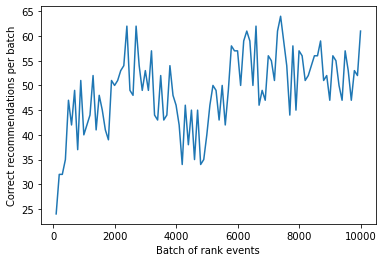

In [17]:
createChart(count,rewards)

In [19]:
#Verify new learning policy and times
get_service_settings() 

-----checking service settings
<Response [200]>
{'name': 'b1c561f6faf943d087cc0442c50d4e73', 'arguments': '--cb_explore_adf --epsilon 0.2 --dsjson --cb_type mtr -q Fj -l 1 --l1 1e-06 --power_t 0'}
<Response [200]>
{'rewardWaitTime': 'PT10M', 'defaultReward': 0.0, 'rewardAggregation': 'earliest', 'explorationPercentage': 0.2, 'modelExportFrequency': 'PT5M', 'logRetentionDays': 90, 'lastConfigurationEditDate': '2021-08-11T07:26:03', 'learningMode': 'Online'}


In [ ]:
# max iterations
num_requests = 2000

# check last mod date N% of time - currently 10%
lastModCheck2 = int(num_requests * .10)

jsonTemplate2 = rankactionsjsonobj

# main iterations
[count2, rewards2] = iterations(num_requests, lastModCheck2, jsonTemplate)

2021-08-11 16:26:33.696055
   1 None Cathy Rainy Evening Cappucino 0 
2021-08-11 16:26:35.734438
   2 None Cathy Sunny Afternoon Cold brew 1 
2021-08-11 16:26:37.312974
   3 None Alice Rainy Evening Cappucino 0 
2021-08-11 16:26:39.044190
   4 None Cathy Rainy Evening Latte 0 
2021-08-11 16:26:40.685087
   5 None Bob Snowy Evening Iced mocha 1 
2021-08-11 16:26:42.277378
   6 None Dave Snowy Afternoon Latte 0 
2021-08-11 16:26:43.981341
   7 None Alice Rainy Morning Cold brew 0 
2021-08-11 16:26:45.826128
   8 None Cathy Rainy Morning Cold brew 0 
2021-08-11 16:26:47.740105
   9 None Cathy Rainy Evening Iced mocha 1 
2021-08-11 16:26:49.364486
   10 None Cathy Snowy Evening Latte 0 
2021-08-11 16:26:51.056796
   11 None Dave Rainy Morning Iced mocha 0 
2021-08-11 16:26:52.705648
   12 None Alice Sunny Afternoon Cappucino 0 
2021-08-11 16:26:54.398041
   13 None Dave Snowy Morning Cappucino 1 
2021-08-11 16:26:56.178644
   14 None Bob Rainy Evening Cold brew 0 
2021-08-11 16:26:57.96397

In [ ]:
createChart(count2,rewards2)